In [13]:
import pandas as pd
import numpy as np
# 数据来源： https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
# 加载数据
df = pd.read_csv('btcusd_1-min_data.csv')

# 转换时间戳并设置索引
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)
print(df.head())
print(f"\n原始数据时间范围: {df.index.min()} 至 {df.index.max()}")

def preprocess(df):
    """
    对比特币数据进行全面预处理：
    1. 处理缺失值
    2. 异常值检测和处理
    3. 创建技术指标特征
    4. 创建时间特征
    """

    report = {
        'original_shape': df.shape,
        'initial_missing': df.isna().sum().to_dict(),
        'initial_zeros': (df == 0).sum().to_dict(),
        'abnormal_count': 0,
        'final_shape': None,
        'features_added': 0
    }
    # 复制原始数据避免修改原数据
    df_clean = df.copy()
    
    missing_before = df_clean[['Open', 'High', 'Low', 'Close', 'Volume']].isna().sum()
    # 对价格使用前向填充+后向填充
    price_cols = ['Open', 'High', 'Low', 'Close']
    df_clean[price_cols] = df_clean[price_cols].ffill().bfill()
    
    # 对成交量使用线性插值+前后填充
    df_clean['Volume'] = df_clean['Volume'].interpolate(method='linear', limit_direction='both')
    
    missing_after = df_clean[['Open', 'High', 'Low', 'Close', 'Volume']].isna().sum()
    # 异常值处理
    # 计算价格变动百分比
    df_clean['Price_Change'] = df_clean['Close'].pct_change(fill_method=None)
    
    # 基于滚动标准差检测异常值
    window = 30  # 30个数据点的窗口
    df_clean['Rolling_Std'] = df_clean['Price_Change'].abs().rolling(window=window).std()
    df_clean['Upper_Bound'] = 4 * df_clean['Rolling_Std']
    df_clean['Lower_Bound'] = -4 * df_clean['Rolling_Std']
    
    # 识别异常波动
    abnormal = (df_clean['Price_Change'] > df_clean['Upper_Bound']) | (df_clean['Price_Change'] < df_clean['Lower_Bound'])
    abnormal_count = abnormal.sum()
    report['abnormal_count'] = abnormal_count  # 记录异常值数量
    original_abnormal = abnormal.sum()
    total_samples = len(df_clean)
    original_ratio = original_abnormal / total_samples * 100
    # 使用中位数平滑
    for col in price_cols:
        # 使用滚动中位数替换异常值
        df_clean.loc[abnormal, col] = df_clean[col].rolling(window=5, center=True).median()
    
    new_price_change = df_clean['Close'].pct_change(fill_method=None)
    new_abnormal = ((new_price_change > df_clean['Upper_Bound']) | 
                    (new_price_change < df_clean['Lower_Bound'])).sum()
    new_ratio = new_abnormal / total_samples * 100
    # 3. 特征工程 - 技术指标
    # 移动平均线
    windows = [5, 10, 20, 50, 100]
    for w in windows:
        df_clean[f'SMA_{w}'] = df_clean['Close'].rolling(window=w).mean()
        df_clean[f'EMA_{w}'] = df_clean['Close'].ewm(span=w, adjust=False).mean()
    
    # 相对强弱指数 (RSI)
    delta = df_clean['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    df_clean['RSI'] = 100 - (100 / (1 + rs))
    
    
    # MACD
    ema12 = df_clean['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df_clean['Close'].ewm(span=26, adjust=False).mean()
    df_clean['MACD'] = ema12 - ema26
    df_clean['Signal_Line'] = df_clean['MACD'].ewm(span=9, adjust=False).mean()
    
    # 波动率指标
    df_clean['Daily_Return'] = df_clean['Close'].pct_change(fill_method=None)
    df_clean['Volatility_7D'] = df_clean['Daily_Return'].rolling(window=7).std() * np.sqrt(7)
    df_clean['Volatility_30D'] = df_clean['Daily_Return'].rolling(window=30).std() * np.sqrt(30)
    
    # 4. 时间特征
    df_clean['Hour'] = df_clean.index.hour
    df_clean['Day_of_Week'] = df_clean.index.dayofweek
    df_clean['Day_of_Month'] = df_clean.index.day
    df_clean['Month'] = df_clean.index.month
    df_clean['Quarter'] = df_clean.index.quarter
    df_clean['Year'] = df_clean.index.year
    df_clean['Weekend'] = df_clean['Day_of_Week'].isin([5, 6]).astype(int)
    
    # 5. 滞后特征 (时间序列特征)
    for lag in [1, 2, 3, 5, 7]:
        df_clean[f'Lag_{lag}_Close'] = df_clean['Close'].shift(lag)
        df_clean[f'Lag_{lag}_Volume'] = df_clean['Volume'].shift(lag)
    
    # 6. 处理特征工程引入的缺失值
    df_clean.dropna(inplace=True)
    
    # 7. 添加价格范围特征
    df_clean['Price_Range'] = df_clean['High'] - df_clean['Low']
    df_clean['Body_Size'] = np.abs(df_clean['Close'] - df_clean['Open'])

    report.update({
        'final_shape': df_clean.shape,
        'features_added': len(df_clean.columns) - len(df.columns),
        'missing_comparison': pd.DataFrame({
            '处理前': missing_before,
            '处理后': missing_after
        })
    })
    report.update({
        'original_abnormal_ratio': f"{original_ratio:.2f}%",
        'new_abnormal_ratio': f"{new_ratio:.2f}%",
        'abnormal_reduction': f"{(original_ratio - new_ratio):.2f}%"
    })

    print("\n=== 数据预处理报告 ===")
    print(f"原始数据集形状: {report['original_shape']}")
    print(f"\n缺失值处理对比:")
    print(report['missing_comparison'])
    print(f"\n异常值处理数量: {report['abnormal_count']}")
    print(f"\n特征工程: 新增 {report['features_added']} 个特征")
    print(f"处理后数据集形状: {report['final_shape']}")
    print(f"\n异常值比例变化: {report['original_abnormal_ratio']} → {report['new_abnormal_ratio']}")
    print(f"异常值减少幅度: {report['abnormal_reduction']}")
    return df_clean


# 重采样函数保持不变
def resample_data(df):
    """重采样到不同时间粒度"""
    # 日级数据
    df_daily = df.resample('D').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()

 
    # 周级数据
    df_weekly = df.resample('W').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()
    
    # 月级数据
    df_monthly = df.resample('ME').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()
    
    # 年级数据
    df_yearly = df.resample('YE').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()
    
    return df_daily, df_weekly, df_monthly, df_yearly

# 预处理数据
df_clean = preprocess(df)

# 重采样数据
df_daily, df_weekly, df_monthly, df_yearly = resample_data(df_clean)
print("\n重采样后样本量统计:")
print(f"日线数据: {len(df_daily)} 条 ({(df_daily.index[-1] - df_daily.index[0]).days} 天)")
print(f"周线数据: {len(df_weekly)} 条 ({(df_weekly.index[-1] - df_weekly.index[0]).days // 7} 周)")
print(f"月线数据: {len(df_monthly)} 个月")
print(f"年线数据: {len(df_yearly)} 年")


                     Open  High   Low  Close  Volume
Timestamp                                           
2012-01-01 10:01:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:02:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:03:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:04:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:05:00  4.58  4.58  4.58   4.58     0.0

原始数据时间范围: 2012-01-01 10:01:00 至 2025-06-04 00:47:00

=== 数据预处理报告 ===
原始数据集形状: (7058607, 5)

缺失值处理对比:
        处理前  处理后
Open      0    0
High      0    0
Low       0    0
Close     0    0
Volume    0    0

异常值处理数量: 102482

特征工程: 新增 39 个特征
处理后数据集形状: (6586008, 44)

异常值比例变化: 1.45% → 0.69%
异常值减少幅度: 0.76%

重采样后样本量统计:
日线数据: 4899 条 (4903 天)
周线数据: 702 条 (701 周)
月线数据: 162 个月
年线数据: 14 年


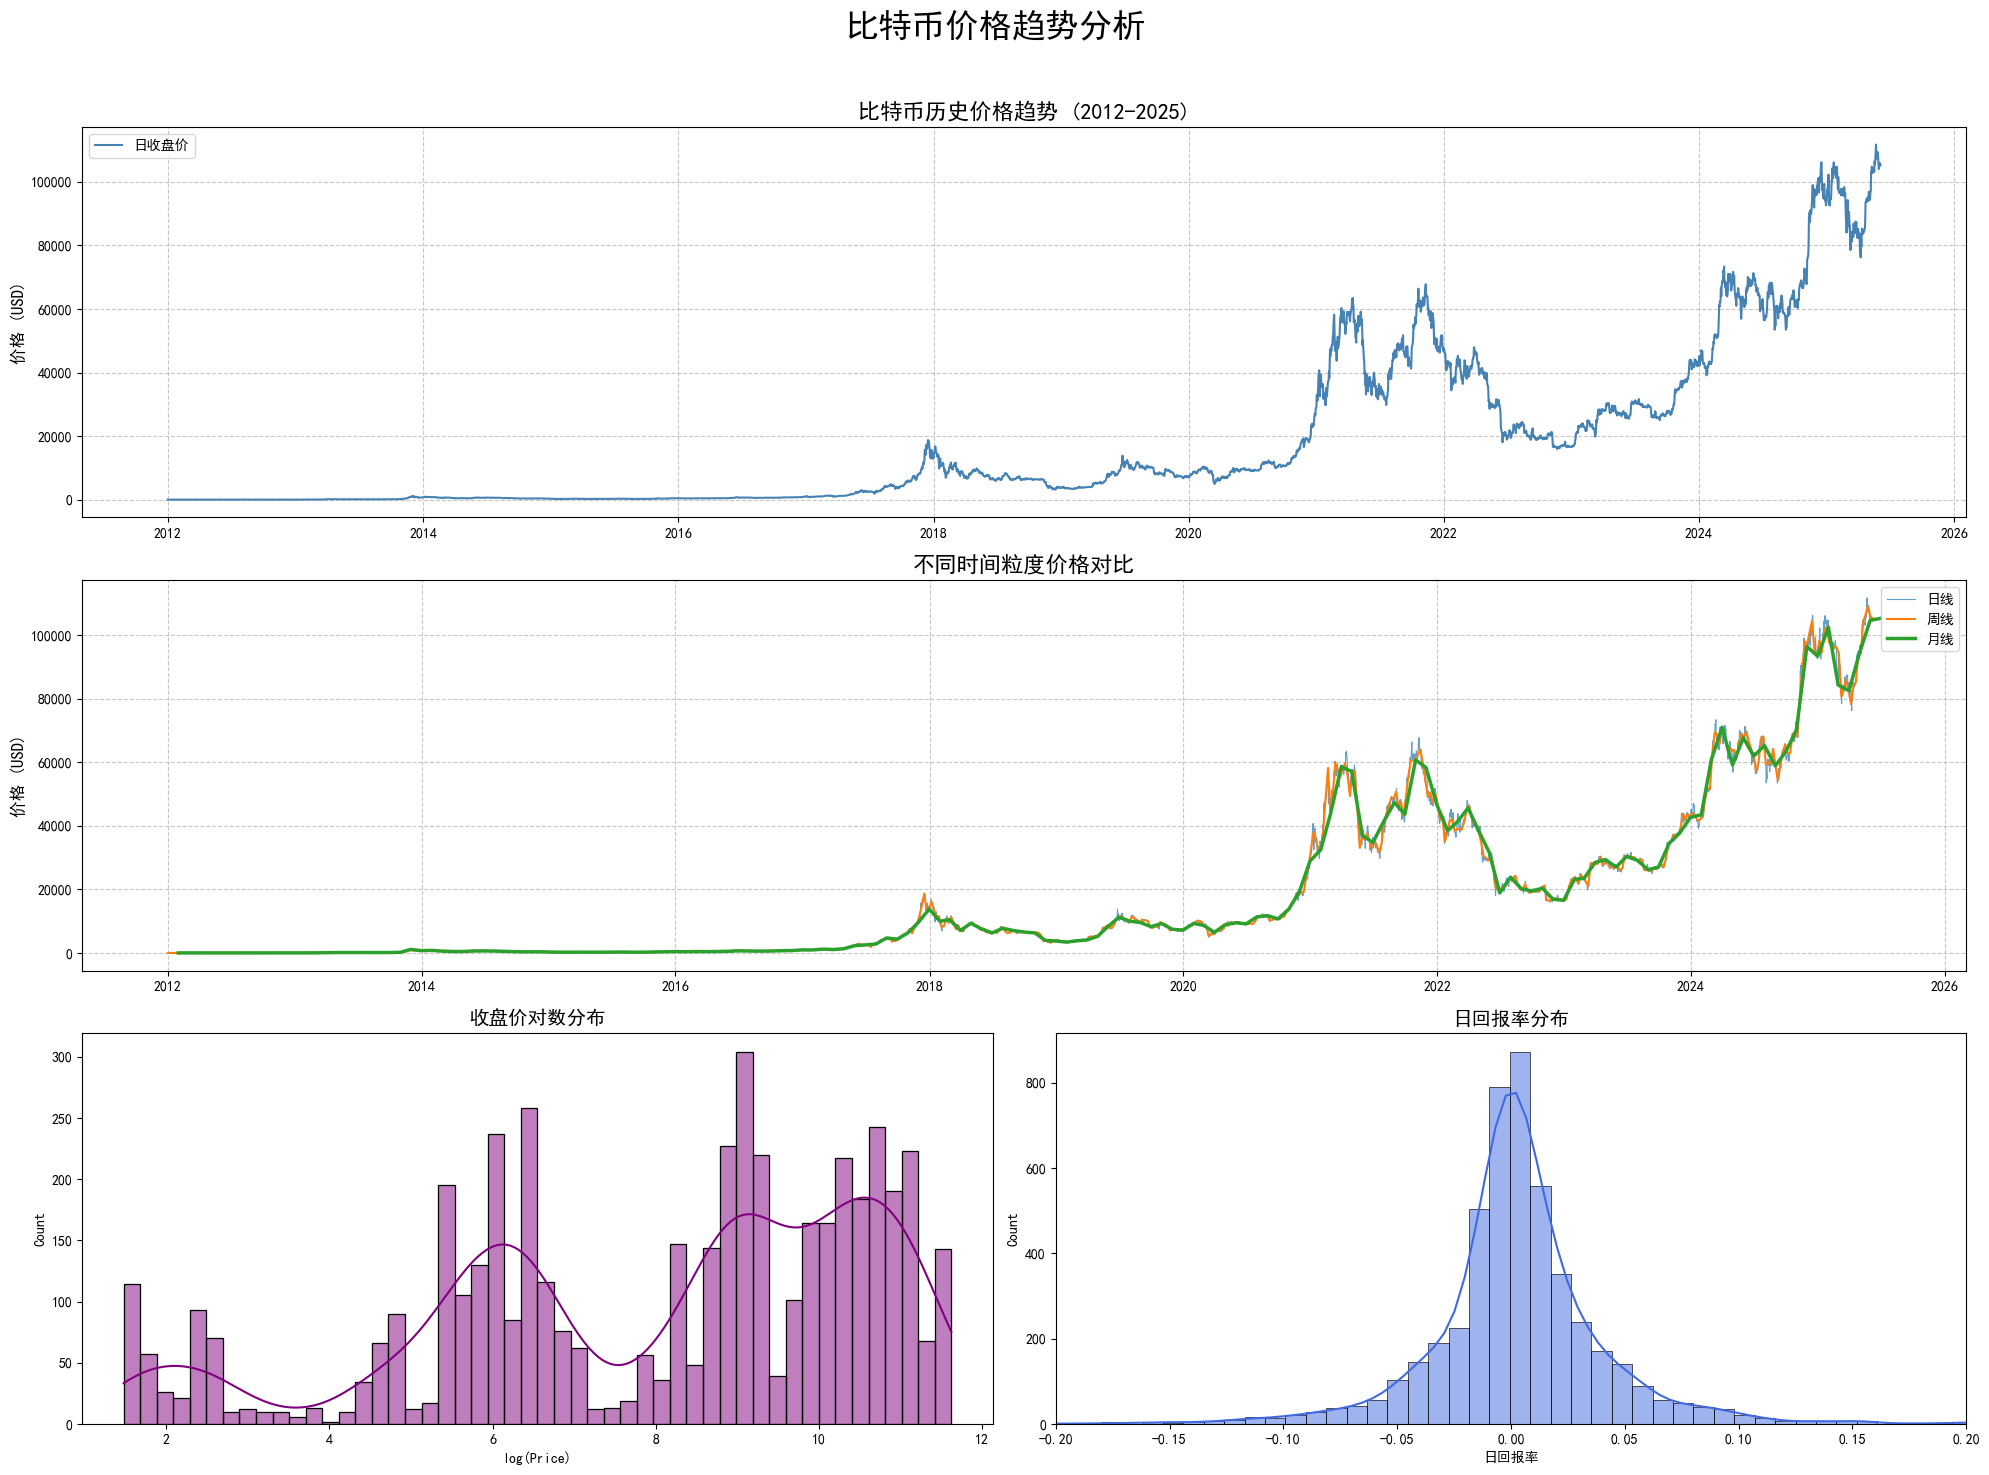

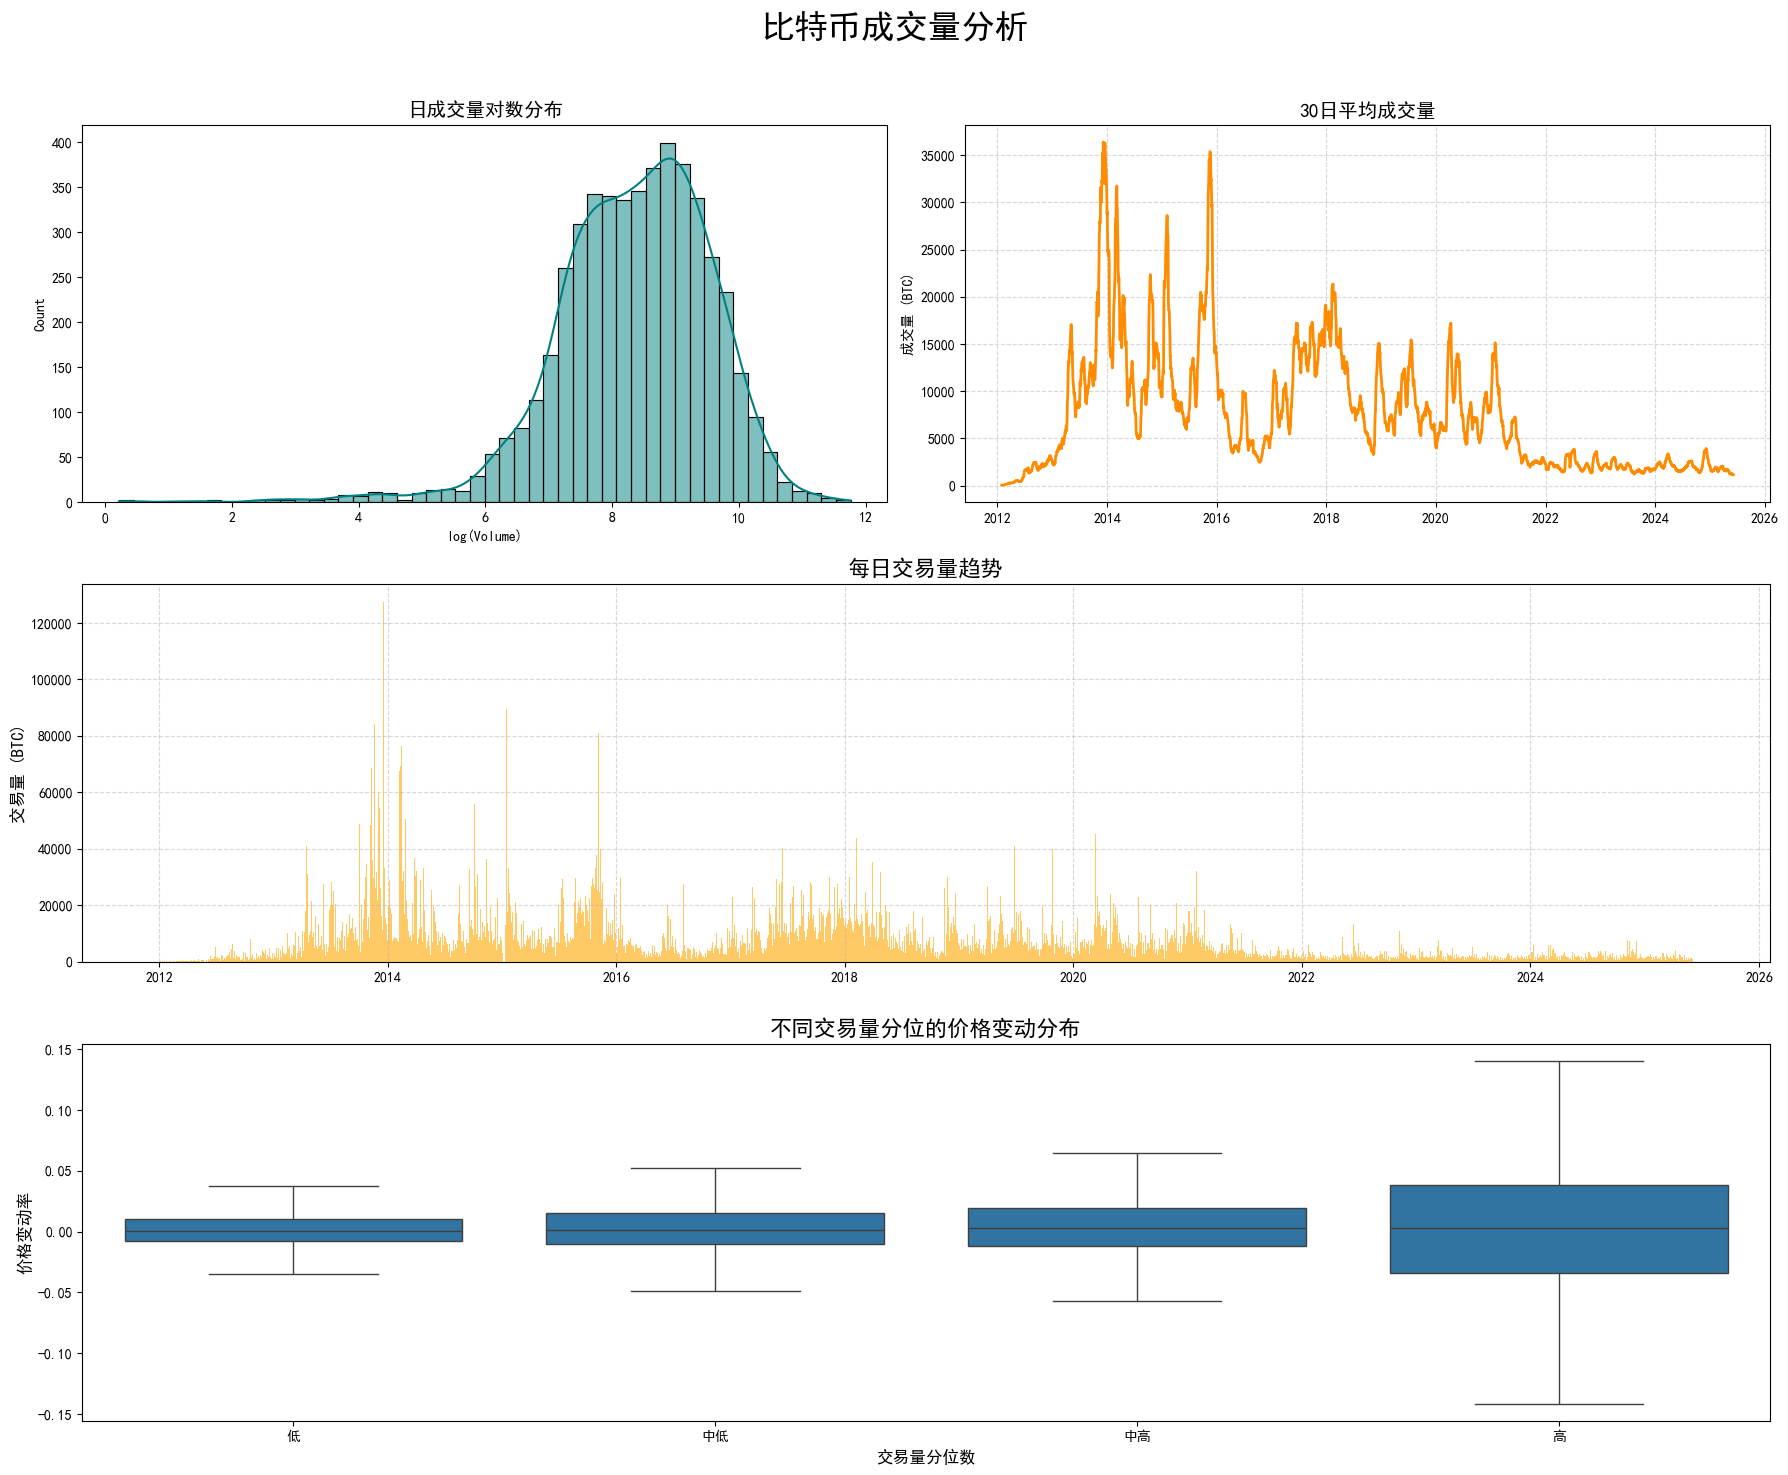

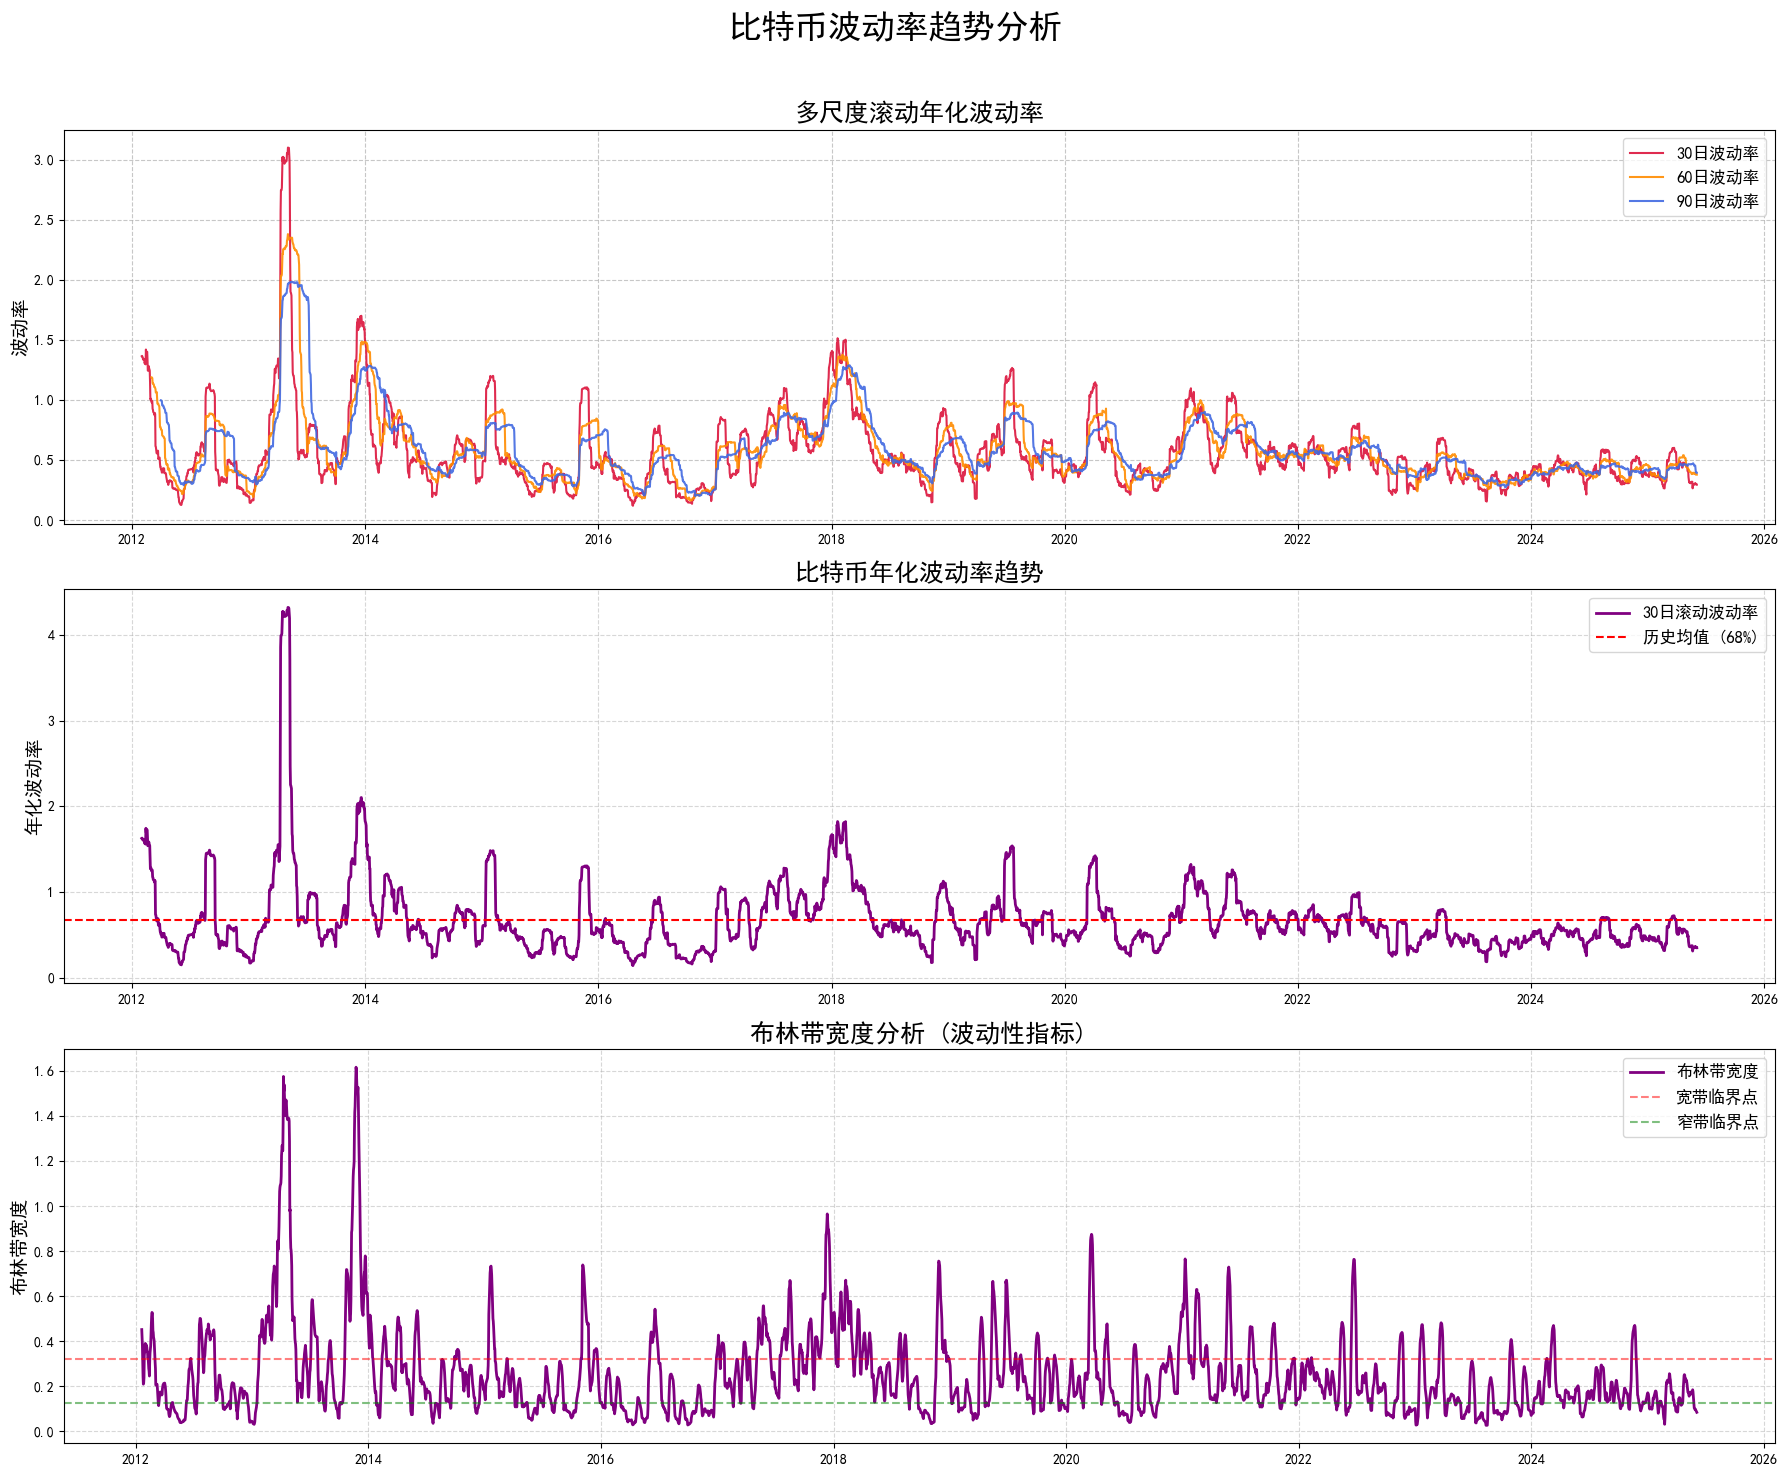

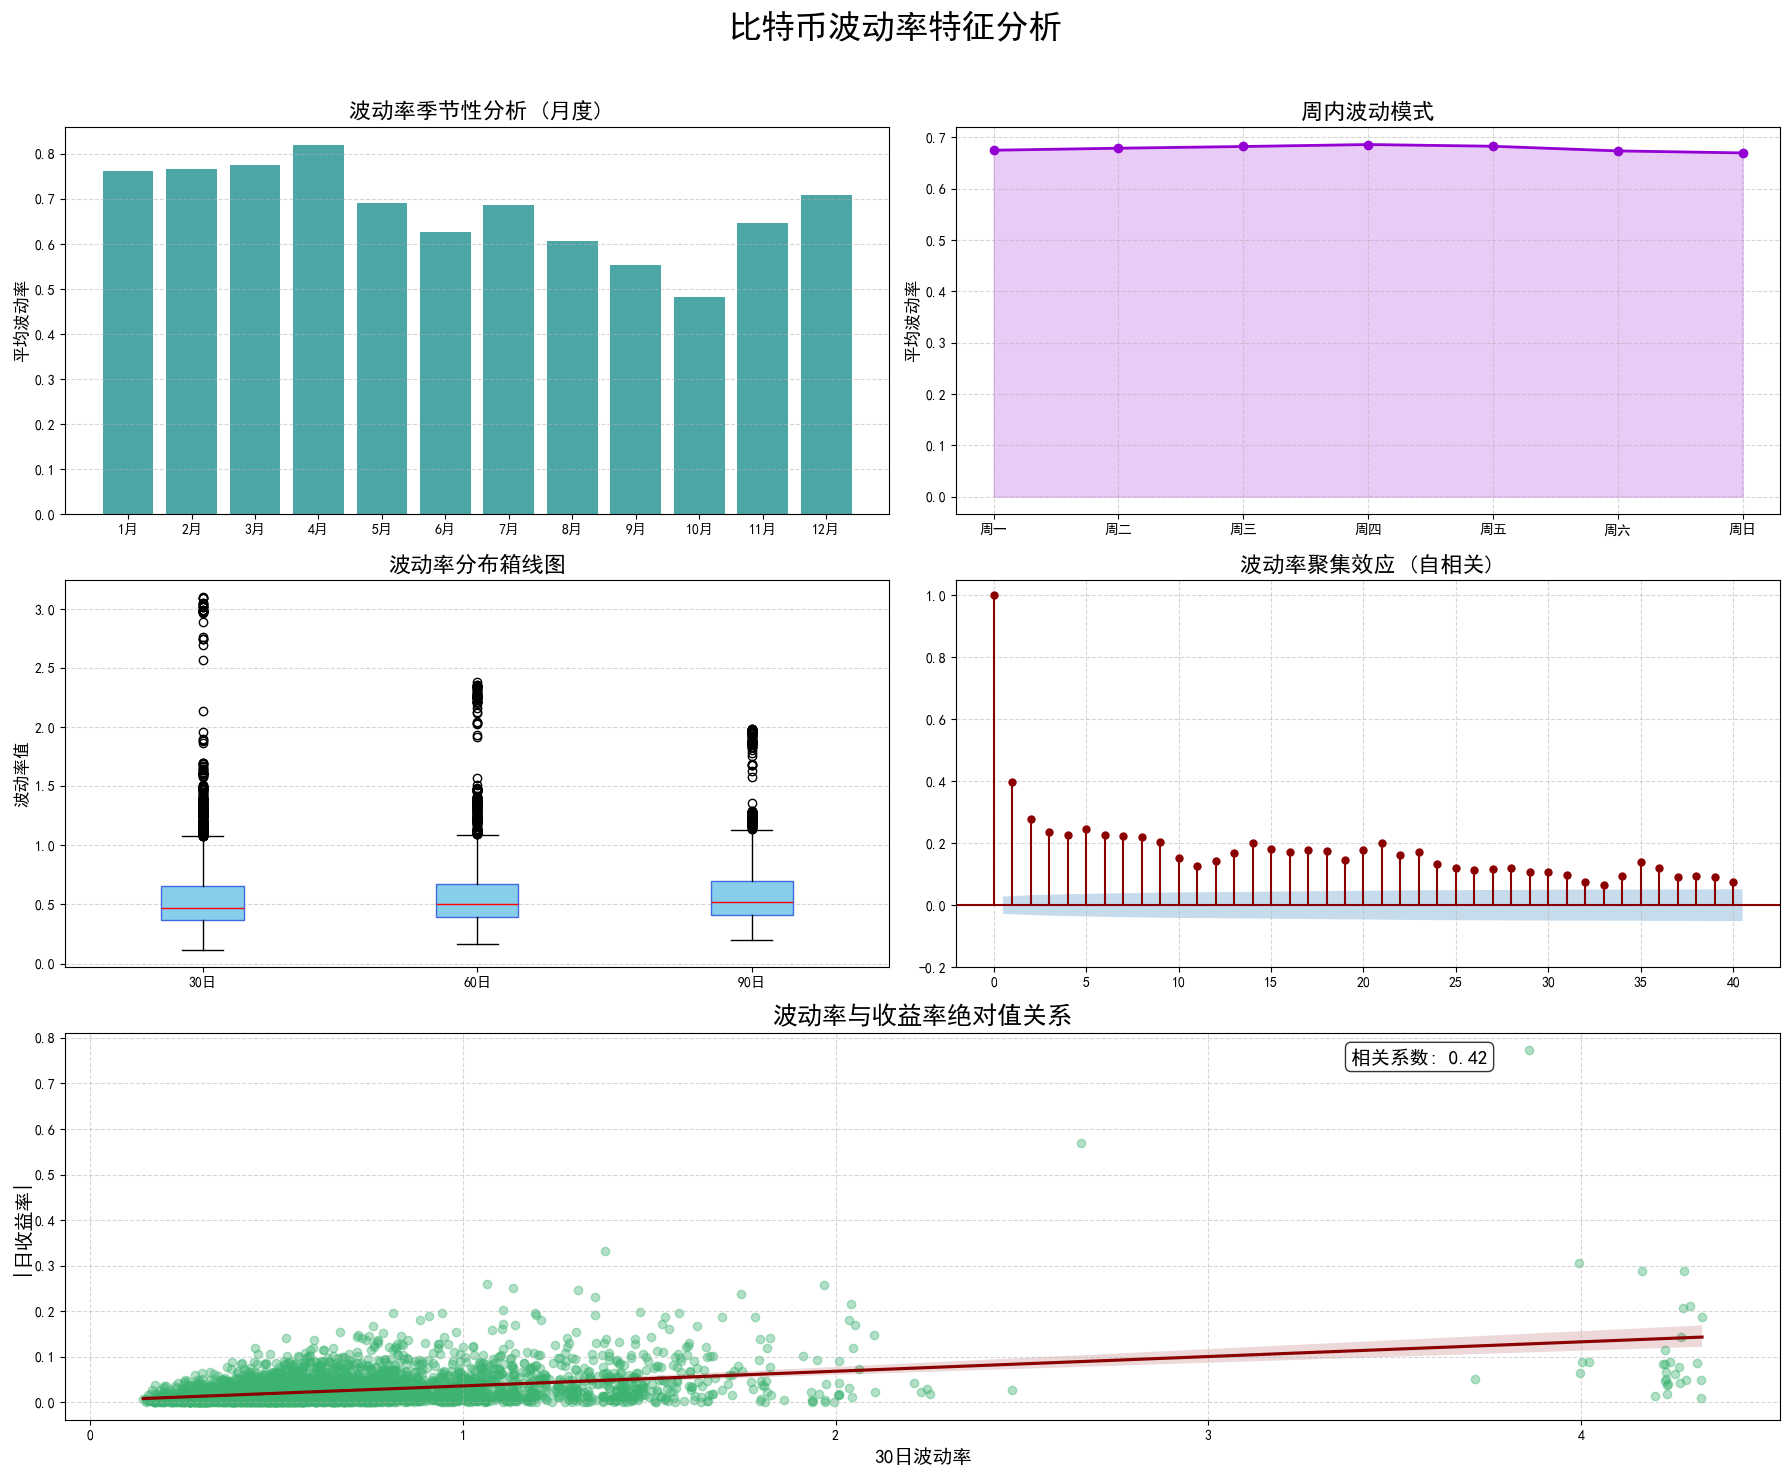

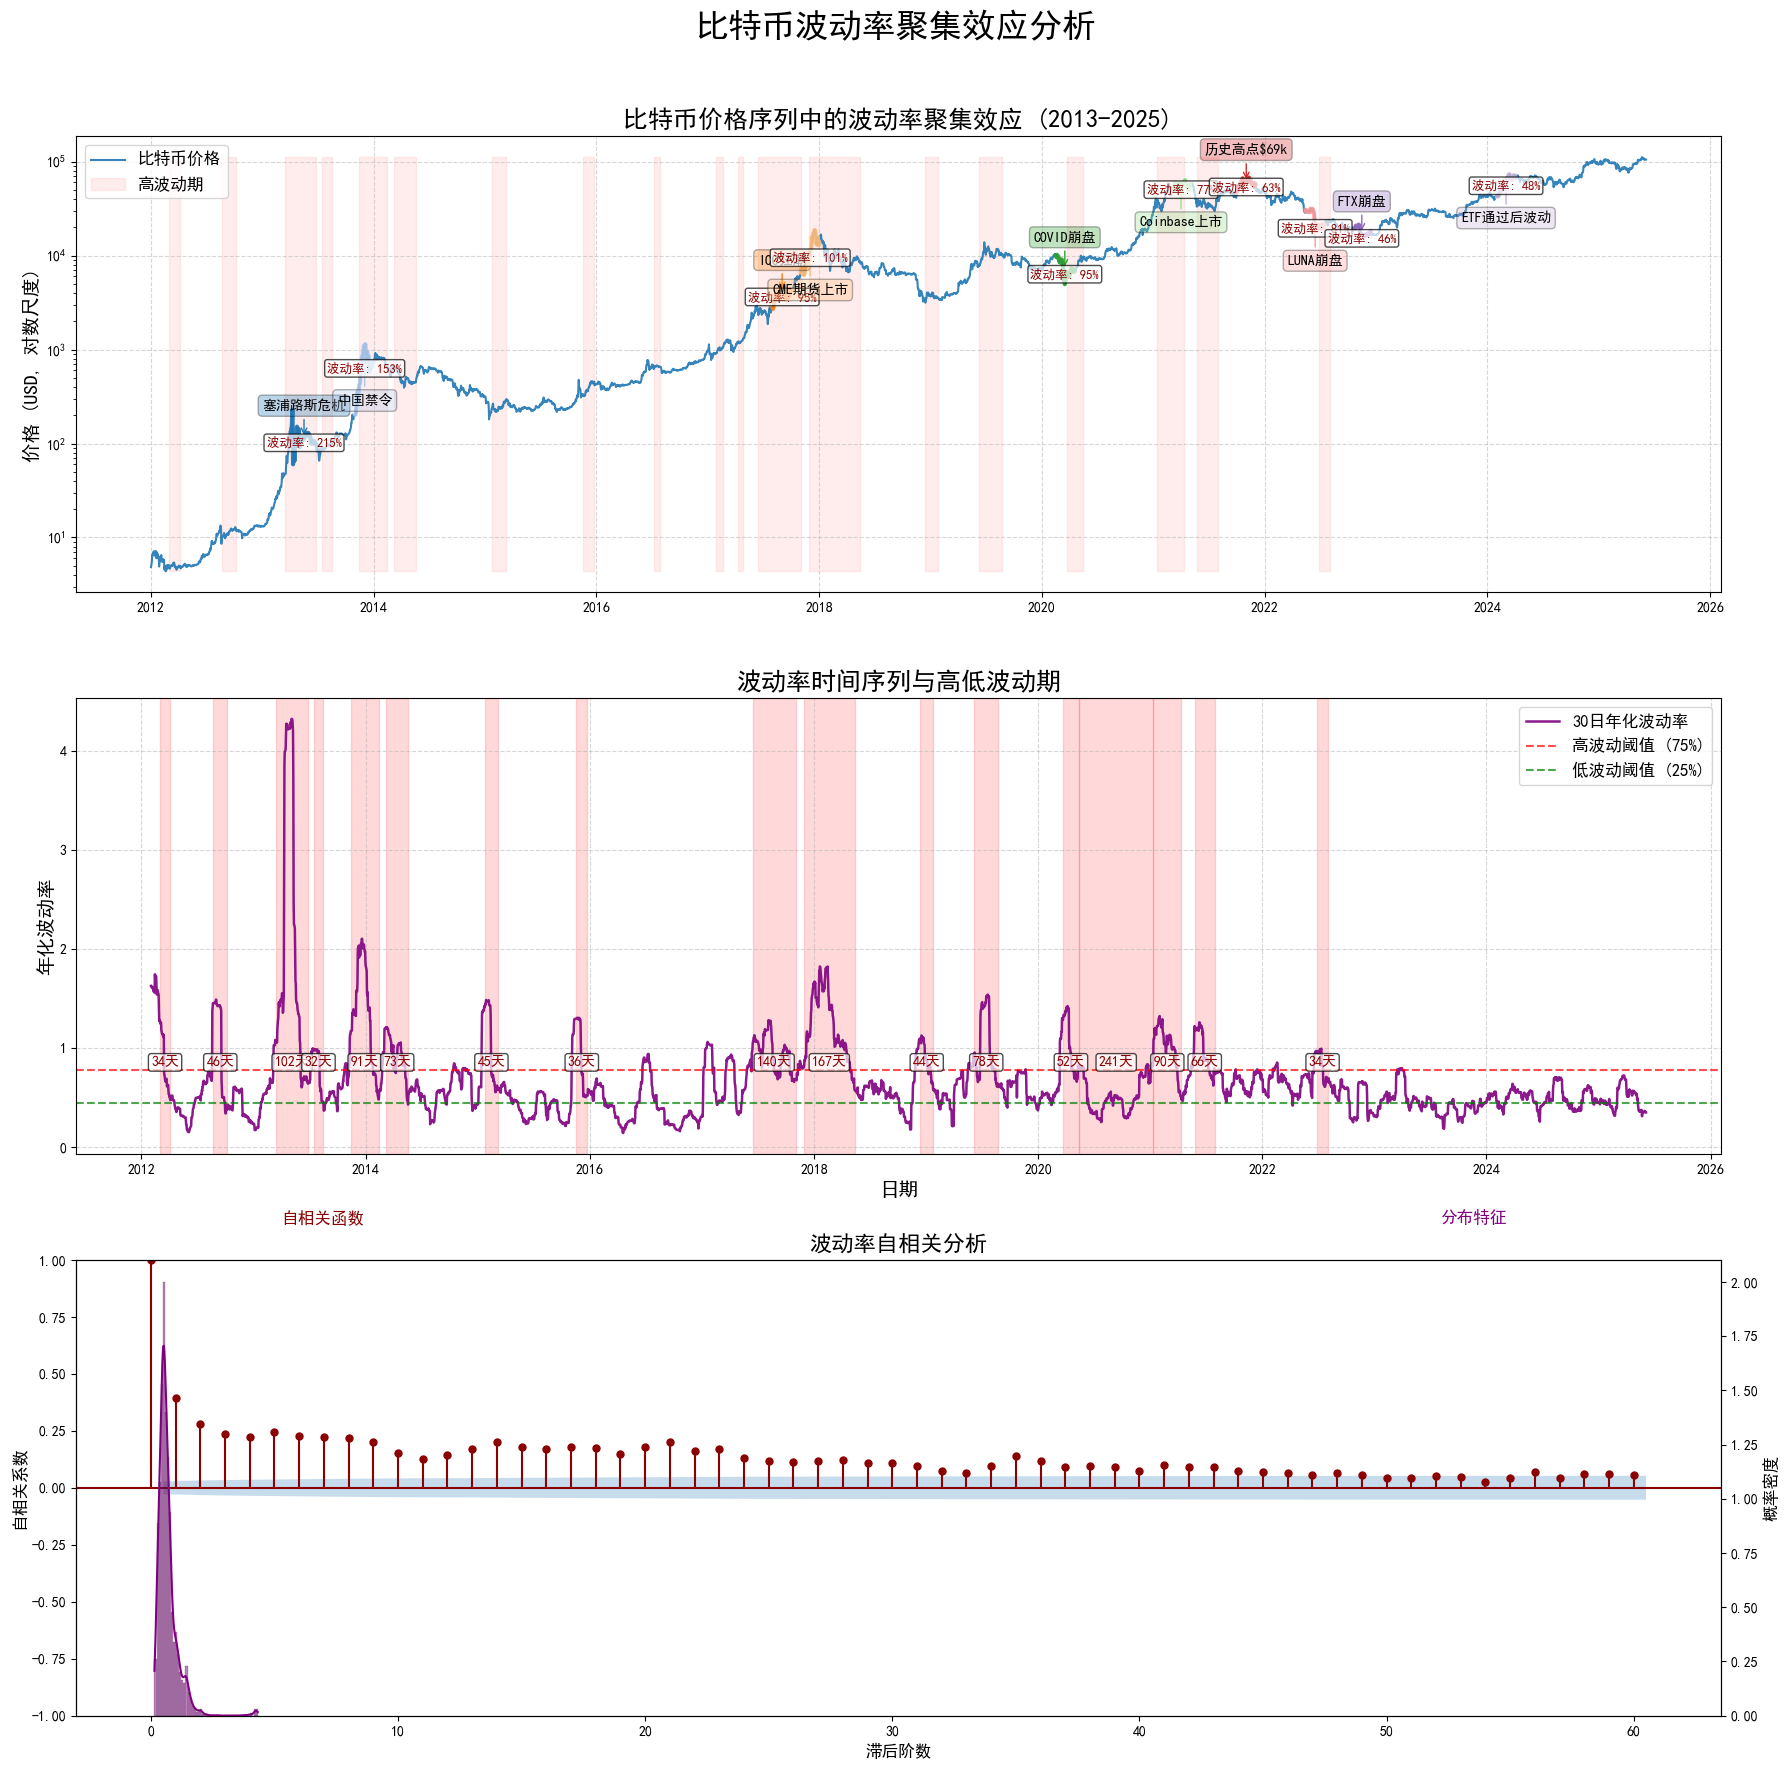


 GARCH(1,1) 模型摘要
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1668.78
Distribution:                  Normal   AIC:                           3343.56
Method:            Maximum Likelihood   BIC:                           3363.05
                                        No. Observations:                 4898
Date:                Fri, Jun 13 2025   Df Residuals:                     4898
Time:                        16:43:35   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.1303e-03  1.632e-03      3.

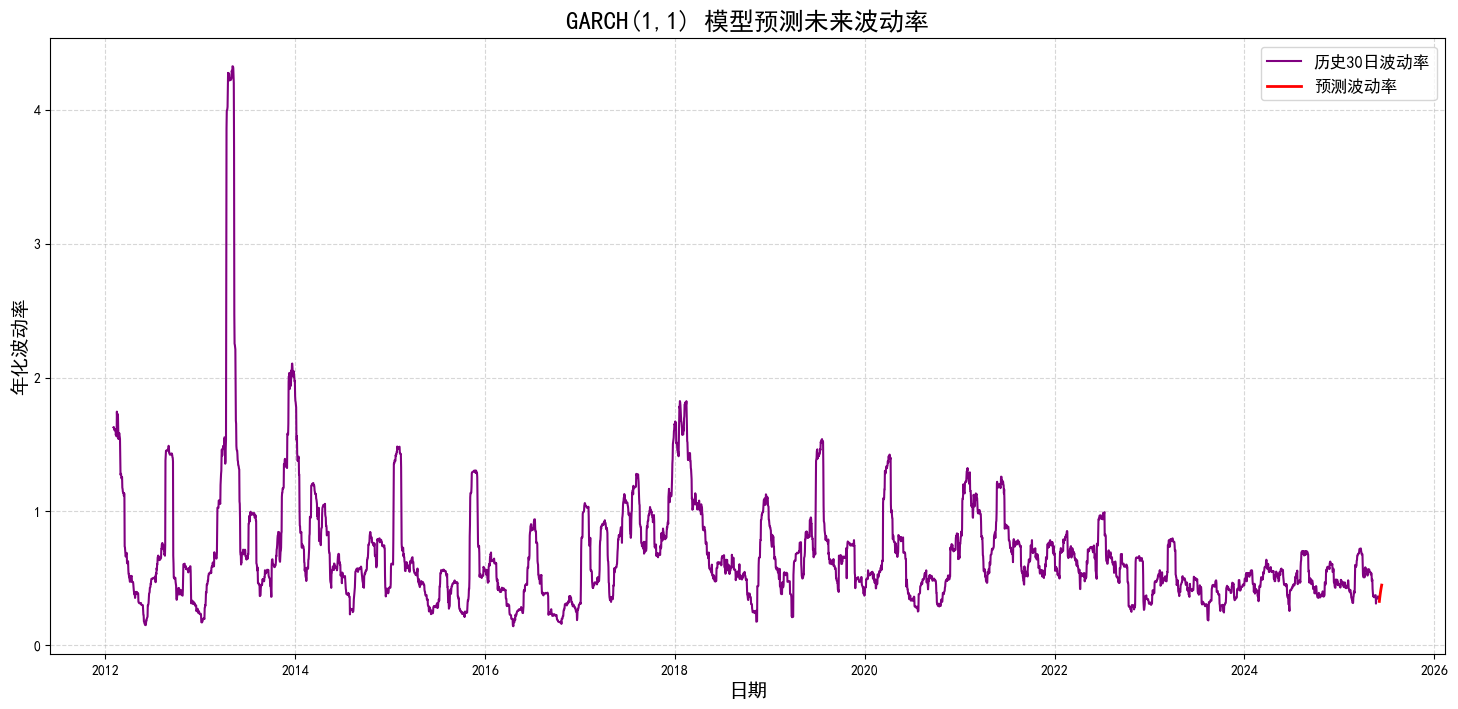

C:\Users\12537\AppData\Local\Temp\ipykernel_14004\663978477.py:438: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = df_daily['Close'][-1]


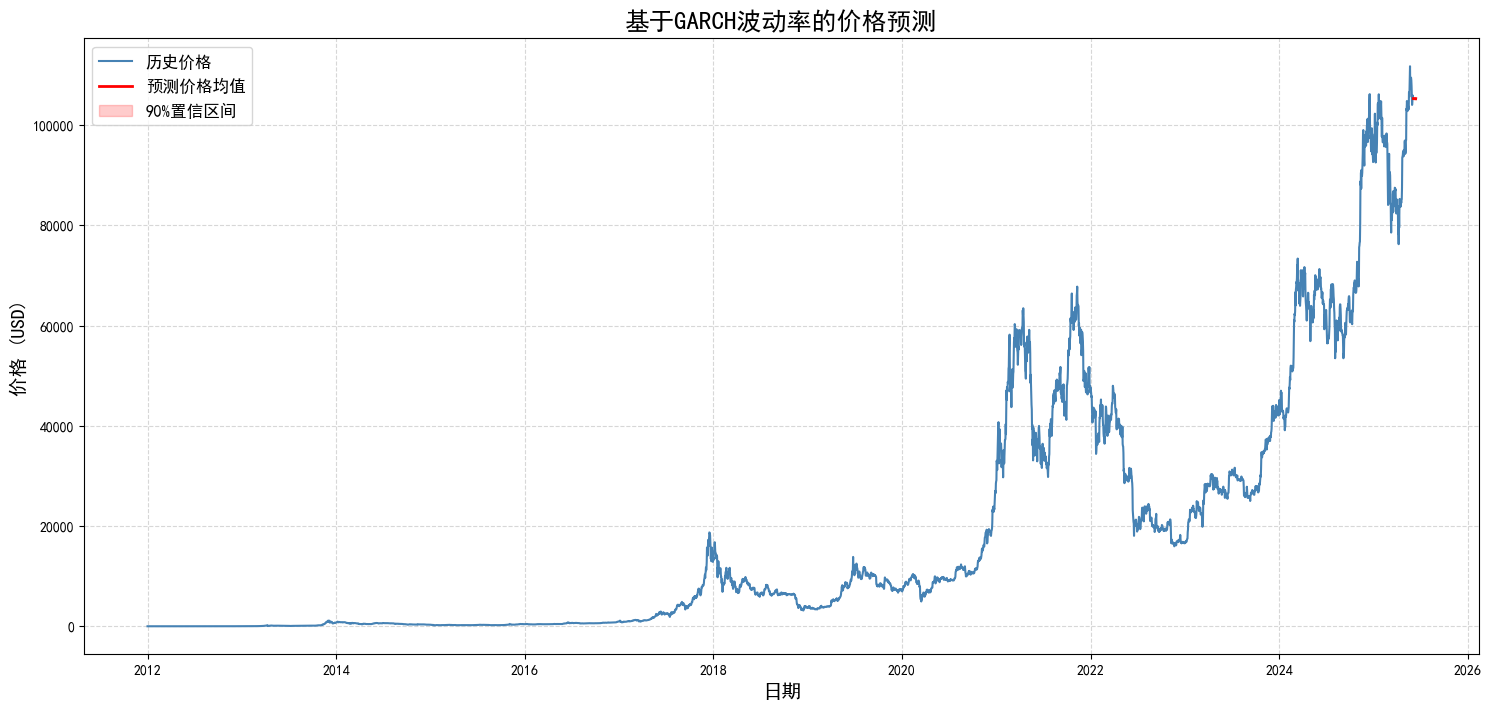

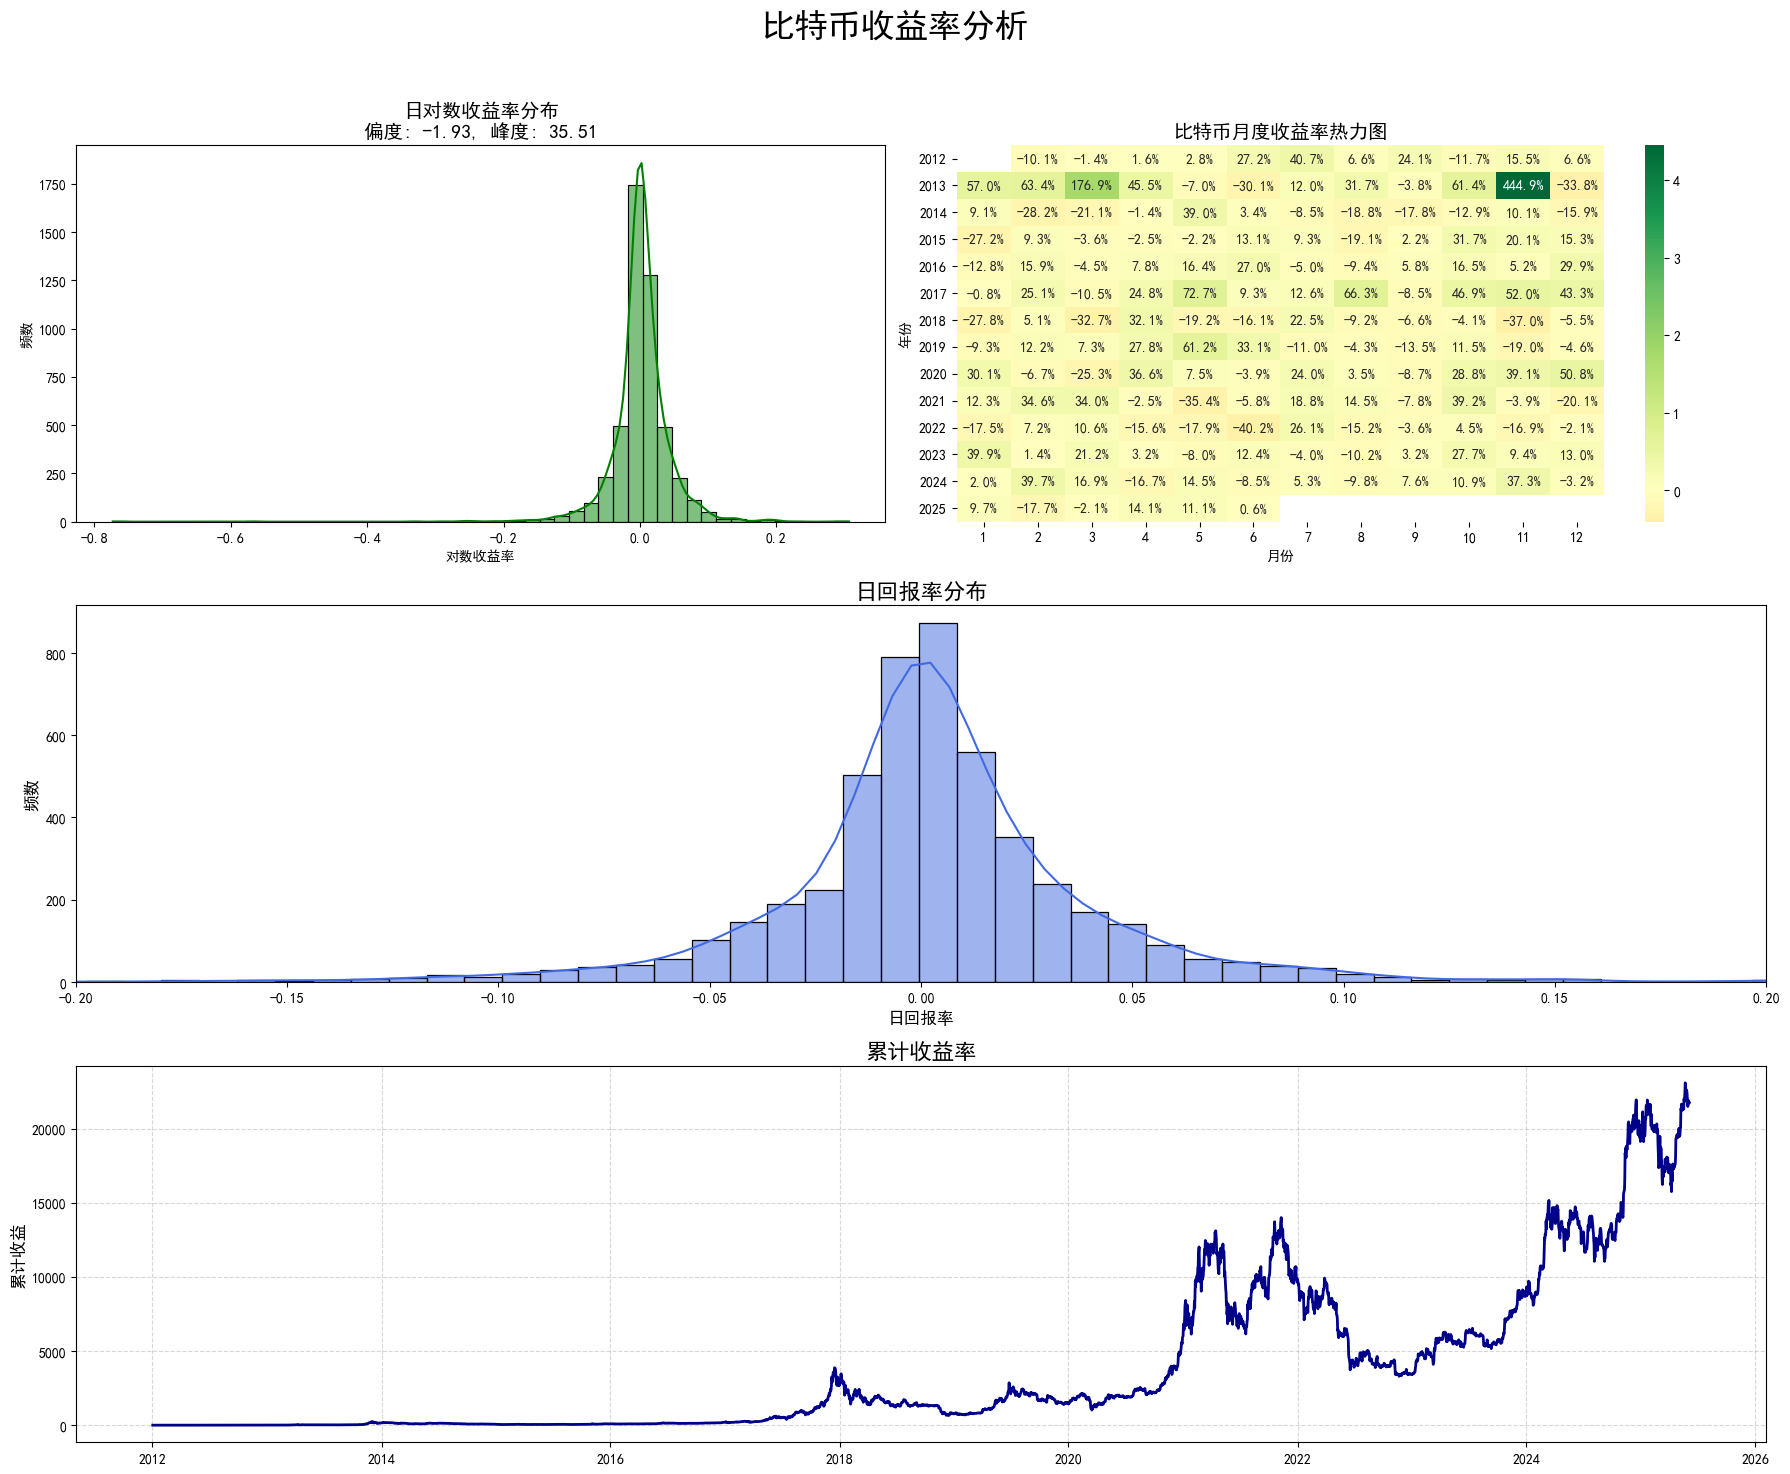

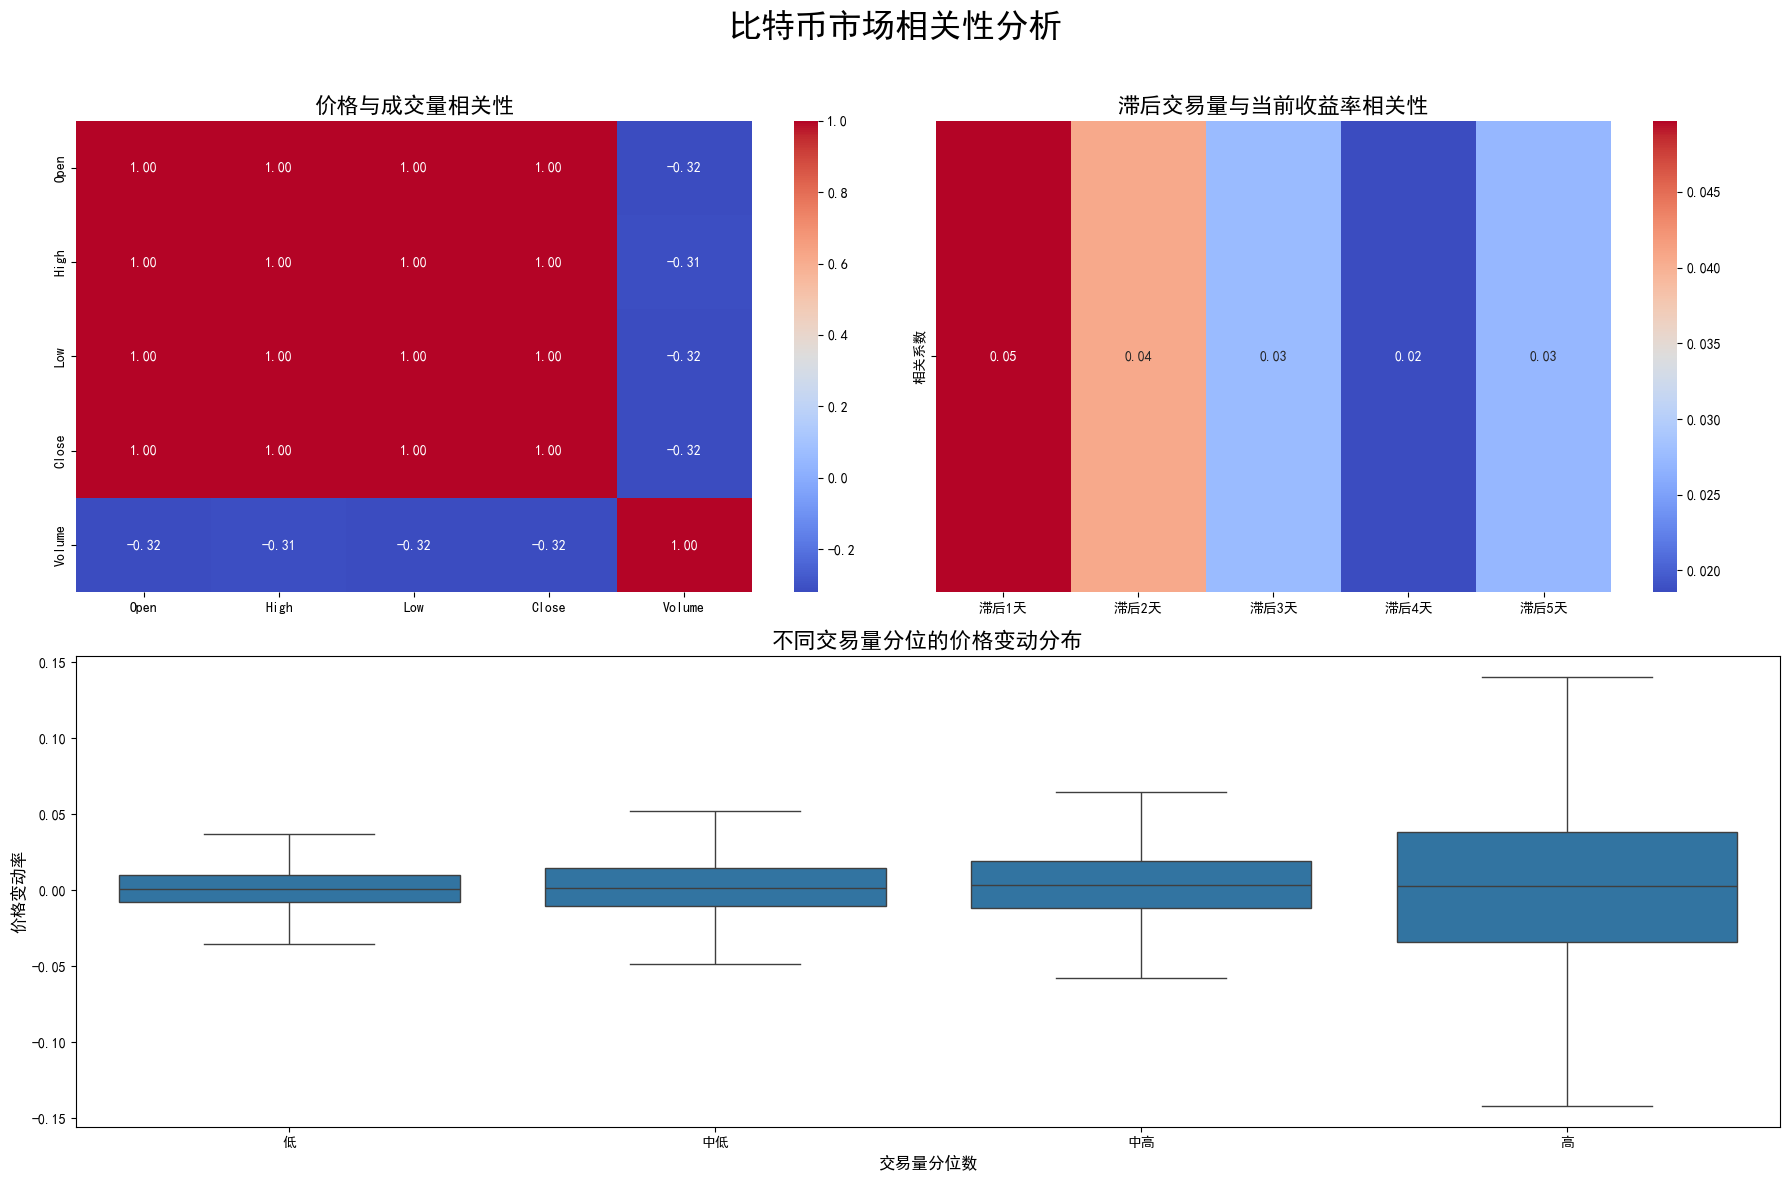

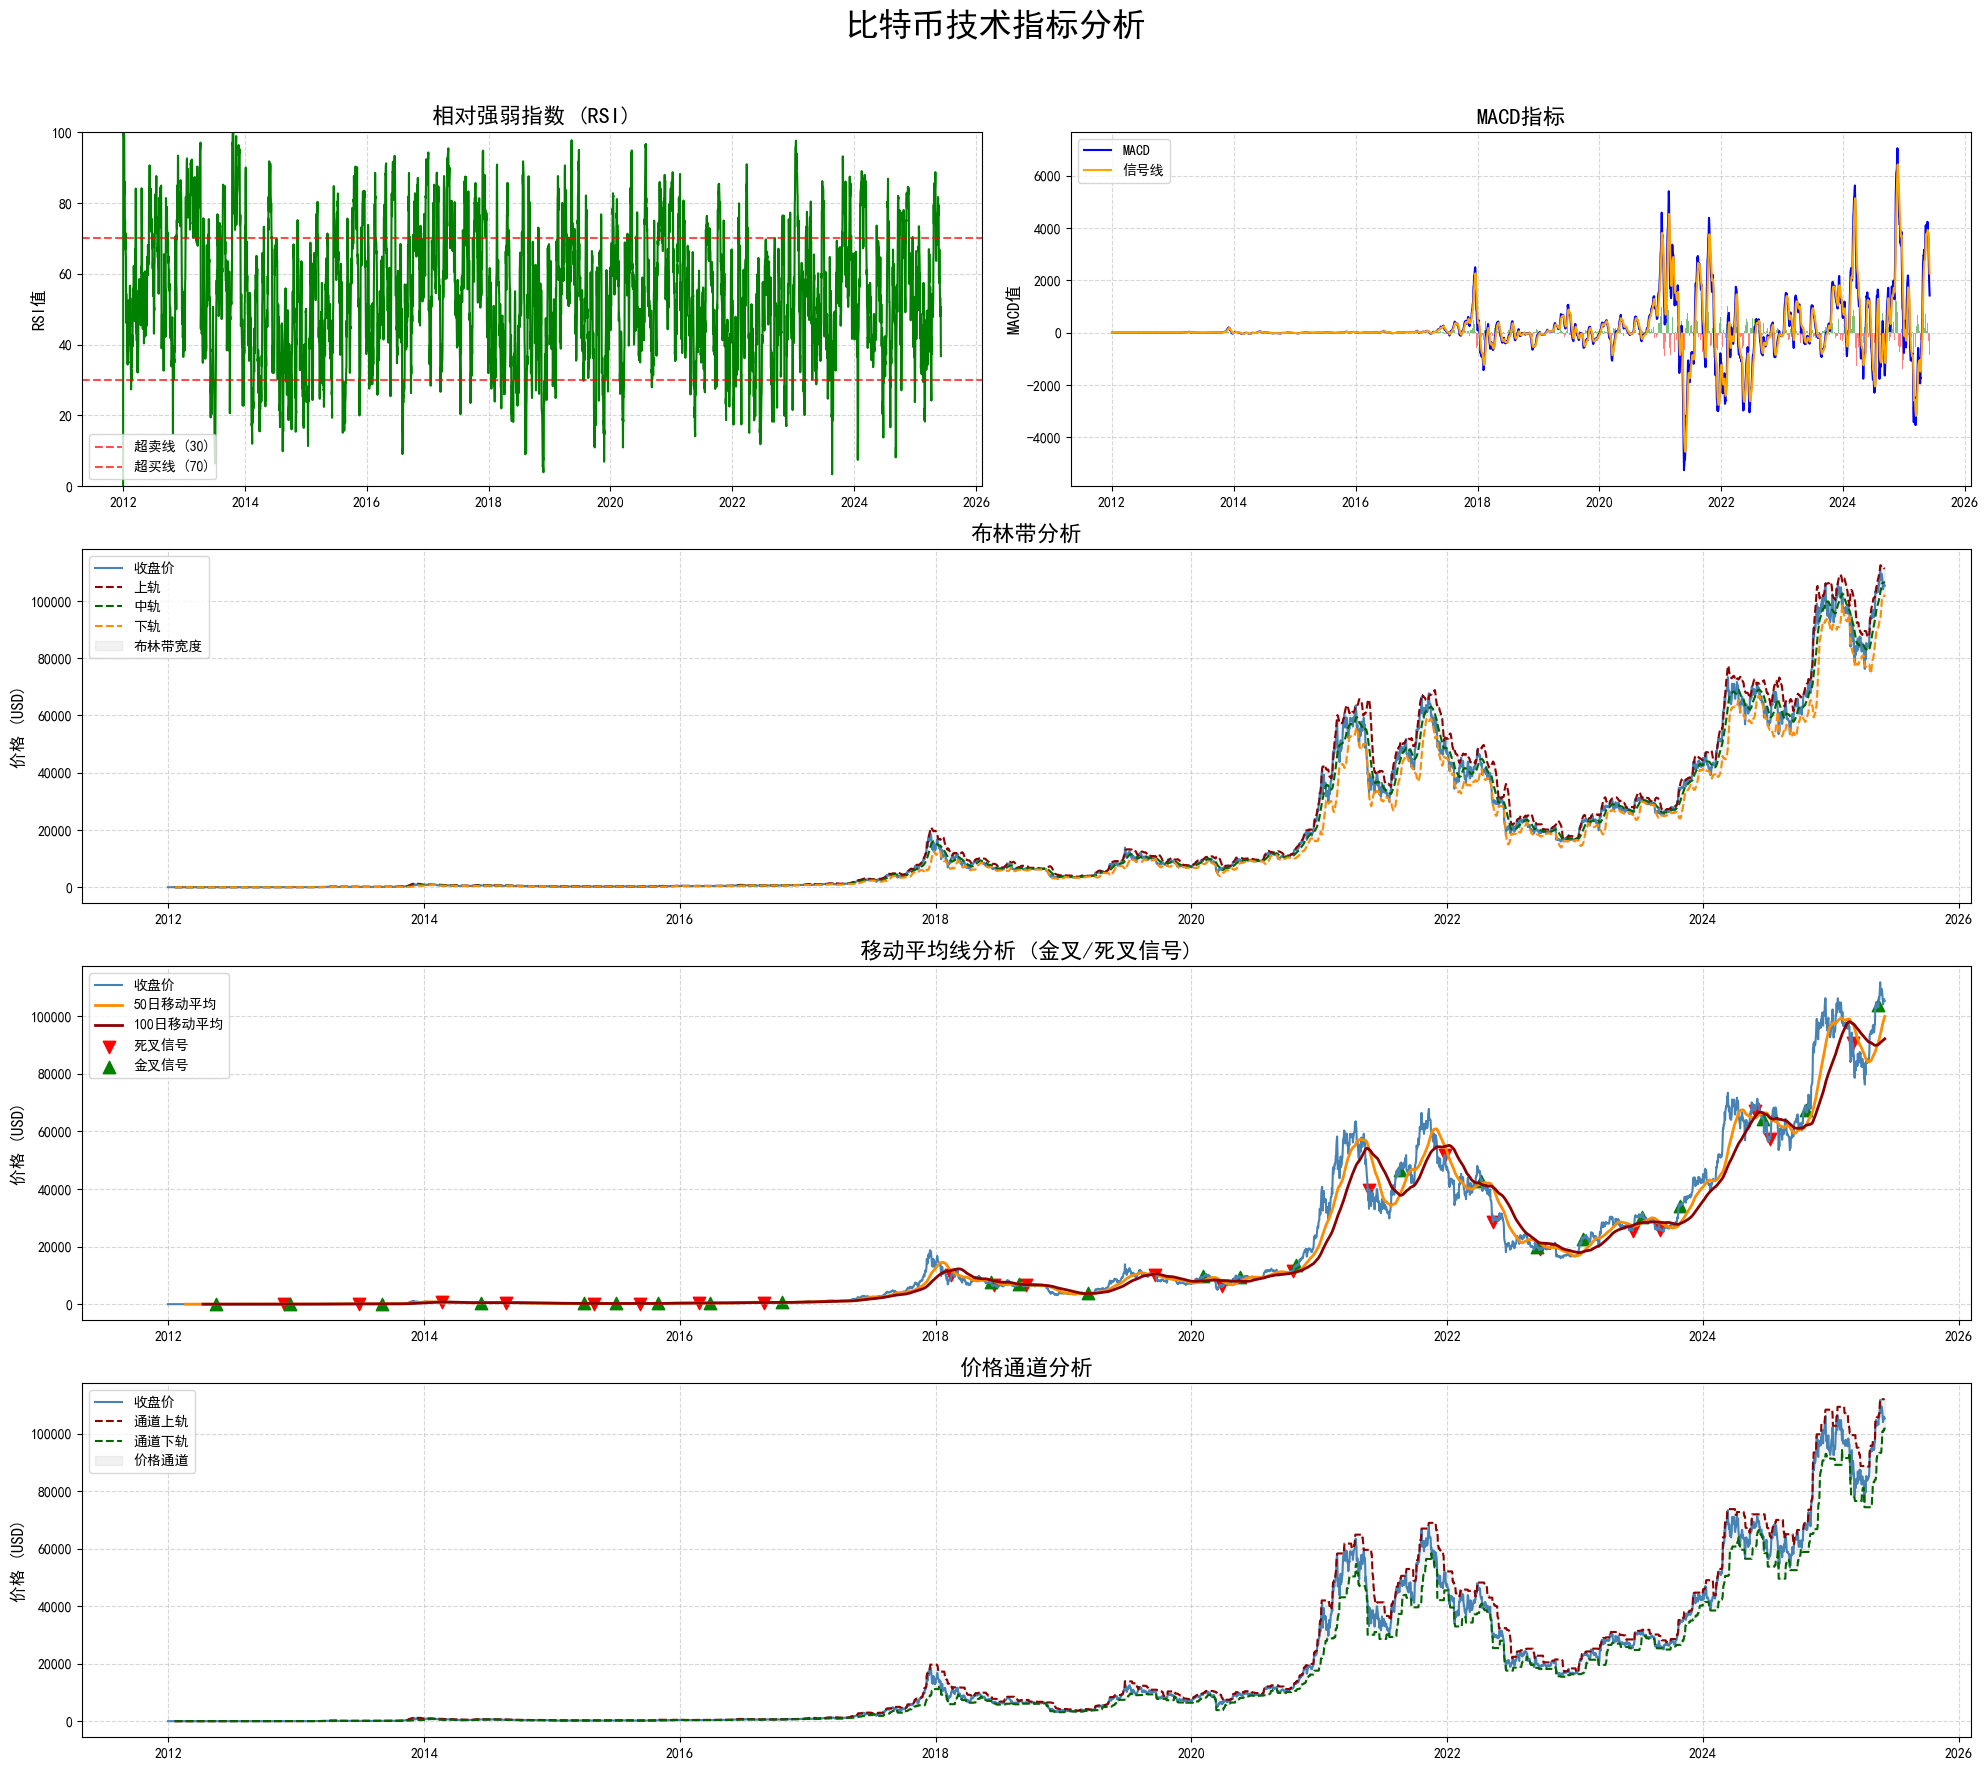

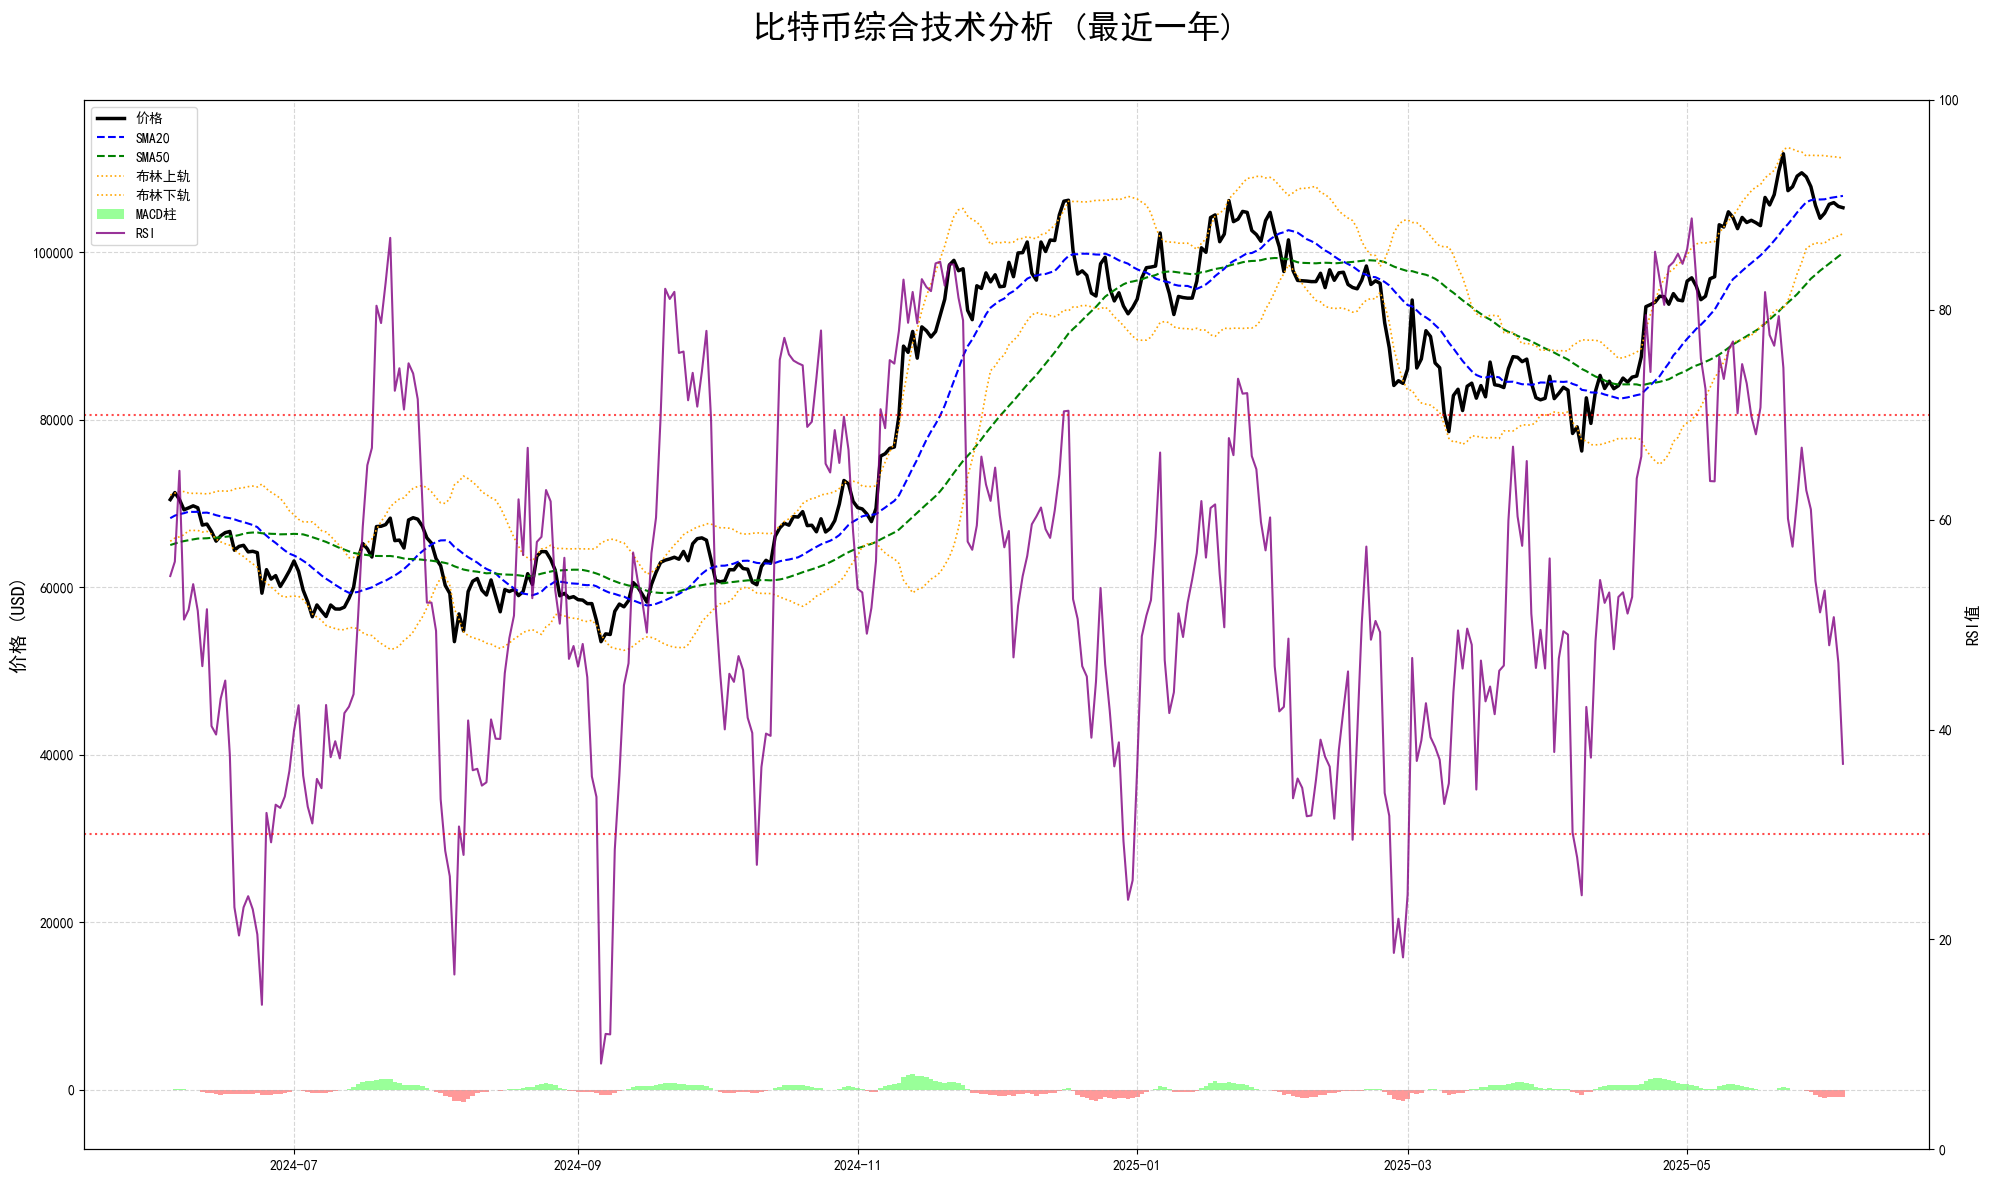

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis
from arch import arch_model

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

# ====================== 技术指标计算 ======================

# 计算对数收益率
df_daily['Log_Return'] = np.log(df_daily['Close'] / df_daily['Close'].shift(1))

# 计算布林带
window = 20
df_daily['Bollinger_Mid'] = df_daily['Close'].rolling(window=window).mean()
df_daily['Bollinger_Std'] = df_daily['Close'].rolling(window=window).std()
df_daily['Bollinger_Upper'] = df_daily['Bollinger_Mid'] + 2 * df_daily['Bollinger_Std']
df_daily['Bollinger_Lower'] = df_daily['Bollinger_Mid'] - 2 * df_daily['Bollinger_Std']
df_daily['Bollinger_Width'] = (df_daily['Bollinger_Upper'] - df_daily['Bollinger_Lower']) / df_daily['Bollinger_Mid'].replace(0, np.nan)

# RSI计算函数
def calculate_rsi(series, period=14):
    try:
        delta = series.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.rolling(window=period, min_periods=1).mean()
        avg_loss = loss.rolling(window=period, min_periods=1).mean()
        
        rs = avg_gain / (avg_loss + 1e-10)  # 避免除以零
        rsi = 100 - (100 / (1 + rs))
        return rsi
    except Exception as e:
        print(f"计算RSI时出错: {e}")
        return pd.Series(np.nan, index=series.index)

# 计算所有技术指标
try:
    # RSI
    df_daily['RSI'] = calculate_rsi(df_daily['Close'])
    
    # MACD
    ema12 = df_daily['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df_daily['Close'].ewm(span=26, adjust=False).mean()
    df_daily['MACD'] = ema12 - ema26
    df_daily['Signal_Line'] = df_daily['MACD'].ewm(span=9, adjust=False).mean()
    
    # 移动平均线
    df_daily['SMA_20'] = df_daily['Close'].rolling(window=20).mean()
    df_daily['SMA_50'] = df_daily['Close'].rolling(window=50).mean()
    df_daily['SMA_100'] = df_daily['Close'].rolling(window=100).mean()
    
    # 价格通道
    df_daily['Channel_High'] = df_daily['High'].rolling(window=20).max()
    df_daily['Channel_Low'] = df_daily['Low'].rolling(window=20).min()
    
except Exception as e:
    print(f"计算技术指标时出错: {e}")

# 1. ====================== 价格趋势分析 ======================
fig1 = plt.figure(figsize=(20, 15))
fig1.suptitle('比特币价格趋势分析', fontsize=24, y=0.98)

gs1 = GridSpec(3, 2, figure=fig1)

# 历史价格趋势
ax1_1 = fig1.add_subplot(gs1[0, :])
ax1_1.plot(df_daily.index, df_daily['Close'], label='日收盘价', color='steelblue', linewidth=1.5)
ax1_1.set_title('比特币历史价格趋势 (2012-2025)', fontsize=16)
ax1_1.set_ylabel('价格 (USD)', fontsize=12)
ax1_1.grid(True, linestyle='--', alpha=0.7)
ax1_1.legend(fontsize=10)

# 不同时间粒度价格对比
ax1_2 = fig1.add_subplot(gs1[1, :])
ax1_2.plot(df_daily.index, df_daily['Close'], label='日线', alpha=0.7, linewidth=0.8)
ax1_2.plot(df_weekly.index, df_weekly['Close'], label='周线', linewidth=1.5)
ax1_2.plot(df_monthly.index, df_monthly['Close'], label='月线', linewidth=2.5)
ax1_2.set_title('不同时间粒度价格对比', fontsize=16)
ax1_2.set_ylabel('价格 (USD)', fontsize=12)
ax1_2.grid(True, linestyle='--', alpha=0.7)
ax1_2.legend(fontsize=10)

# 收盘价对数分布
ax1_3 = fig1.add_subplot(gs1[2, 0])
sns.histplot(np.log(df_daily['Close']), kde=True, ax=ax1_3, color='purple', bins=50)
ax1_3.set_title('收盘价对数分布', fontsize=14)
ax1_3.set_xlabel('log(Price)', fontsize=10)

# 日回报率分布
df_daily['Returns'] = df_daily['Close'].pct_change(fill_method=None)
ax1_4 = fig1.add_subplot(gs1[2, 1])
sns.histplot(df_daily['Returns'].dropna(), kde=True, ax=ax1_4, color='royalblue', bins=100)
ax1_4.set_title('日回报率分布', fontsize=14)
ax1_4.set_xlim(-0.2, 0.2)
ax1_4.set_xlabel('日回报率', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('price_analysis.png', dpi=300, bbox_inches='tight')

# 2. ====================== 成交量分析 ======================
fig2 = plt.figure(figsize=(18, 15))
fig2.suptitle('比特币成交量分析', fontsize=24, y=0.98)

gs2 = GridSpec(3, 2, figure=fig2)

# 日成交量对数分布
ax2_1 = fig2.add_subplot(gs2[0, 0])
sns.histplot(np.log1p(df_daily['Volume']), kde=True, ax=ax2_1, color='teal', bins=50)
ax2_1.set_title('日成交量对数分布', fontsize=14)
ax2_1.set_xlabel('log(Volume)', fontsize=10)

# 30日平均成交量
ax2_2 = fig2.add_subplot(gs2[0, 1])
df_daily['Volume_MA30'] = df_daily['Volume'].rolling(30).mean()
ax2_2.plot(df_daily.index, df_daily['Volume_MA30'], color='darkorange', linewidth=2)
ax2_2.set_title('30日平均成交量', fontsize=14)
ax2_2.set_ylabel('成交量 (BTC)', fontsize=10)
ax2_2.grid(True, linestyle='--', alpha=0.5)

# 每日交易量趋势
ax2_3 = fig2.add_subplot(gs2[1, :])
ax2_3.bar(df_daily.index, df_daily['Volume'], color='orange', alpha=0.6, width=1.0)
ax2_3.set_title('每日交易量趋势', fontsize=16)
ax2_3.set_ylabel('交易量 (BTC)', fontsize=12)
ax2_3.grid(True, linestyle='--', alpha=0.5)

# 交易量分位与价格变动
df_daily['Price_Change'] = df_daily['Close'].pct_change()
df_daily['Volume_Quantile'] = pd.qcut(df_daily['Volume'], q=4, labels=['低', '中低', '中高', '高'])
ax2_4 = fig2.add_subplot(gs2[2, :])
sns.boxplot(x='Volume_Quantile', y='Price_Change', data=df_daily, showfliers=False)
ax2_4.set_title('不同交易量分位的价格变动分布', fontsize=16)
ax2_4.set_xlabel('交易量分位数', fontsize=12)
ax2_4.set_ylabel('价格变动率', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('volume_analysis.png', dpi=300, bbox_inches='tight')

# 3. ====================== 波动率分析 ======================
# 计算30日波动率
df_daily['30D_Vol'] = df_daily['Log_Return'].rolling(30).std() * np.sqrt(365)

# 创建两个figure：一个用于趋势分析，一个用于特征分析
fig3_trend = plt.figure(figsize=(18, 15))
fig3_trend.suptitle('比特币波动率趋势分析', fontsize=24, y=0.98)
gs3_trend = GridSpec(3, 1, figure=fig3_trend)

# 多尺度滚动年化波动率
ax3_1 = fig3_trend.add_subplot(gs3_trend[0])
windows = [30, 60, 90]
colors = ['crimson', 'darkorange', 'royalblue']
labels = ['30日', '60日', '90日']

for window, color, label in zip(windows, colors, labels):
    df_daily[f'Vol_{window}D'] = df_daily['Returns'].rolling(window).std() * np.sqrt(252)
    ax3_1.plot(df_daily.index, df_daily[f'Vol_{window}D'], color=color, 
               linewidth=1.5, alpha=0.9, label=f'{label}波动率')
    
ax3_1.set_title('多尺度滚动年化波动率', fontsize=18)
ax3_1.set_ylabel('波动率', fontsize=14)
ax3_1.grid(True, linestyle='--', alpha=0.7)
ax3_1.legend(fontsize=12, loc='upper right')

# 对数收益率波动率趋势
ax3_2 = fig3_trend.add_subplot(gs3_trend[1])
mean_vol_log = df_daily['30D_Vol'].mean()
ax3_2.plot(df_daily.index, df_daily['30D_Vol'], color='purple', linewidth=2, label='30日滚动波动率')
ax3_2.axhline(y=mean_vol_log, color='red', linestyle='--', label=f'历史均值 ({mean_vol_log*100:.0f}%)')
ax3_2.set_title('比特币年化波动率趋势', fontsize=18)
ax3_2.set_ylabel('年化波动率', fontsize=14)
ax3_2.legend(fontsize=12)
ax3_2.grid(True, linestyle='--', alpha=0.5)

# 布林带宽度分析
ax3_3 = fig3_trend.add_subplot(gs3_trend[2])
ax3_3.plot(df_daily.index, df_daily['Bollinger_Width'], color='purple', linewidth=2, label='布林带宽度')
ax3_3.axhline(y=df_daily['Bollinger_Width'].quantile(0.75), color='red', linestyle='--', 
              alpha=0.5, label='宽带临界点')
ax3_3.axhline(y=df_daily['Bollinger_Width'].quantile(0.25), color='green', linestyle='--', 
              alpha=0.5, label='窄带临界点')
ax3_3.set_title('布林带宽度分析 (波动性指标)', fontsize=18)
ax3_3.set_ylabel('布林带宽度', fontsize=14)
ax3_3.legend(fontsize=12)
ax3_3.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('volatility_trends.png', dpi=300, bbox_inches='tight')

# 波动率特征分析
fig3_features = plt.figure(figsize=(18, 15))
fig3_features.suptitle('比特币波动率特征分析', fontsize=24, y=0.98)
gs3_features = GridSpec(3, 2, figure=fig3_features)

# 波动率季节性分析 (月度)
ax3_4 = fig3_features.add_subplot(gs3_features[0, 0])
df_daily['Month'] = df_daily.index.month
monthly_vol = df_daily.groupby('Month')['30D_Vol'].mean()
months = ['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月']
ax3_4.bar(months, monthly_vol, color='teal', alpha=0.7)
ax3_4.set_title('波动率季节性分析 (月度)', fontsize=16)
ax3_4.set_ylabel('平均波动率', fontsize=12)
ax3_4.grid(axis='y', linestyle='--', alpha=0.5)

# 周内波动模式
ax3_5 = fig3_features.add_subplot(gs3_features[0, 1])
df_daily['Weekday'] = df_daily.index.weekday
weekday_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
weekday_vol = df_daily.groupby('Weekday')['30D_Vol'].mean()
ax3_5.plot(weekday_names, weekday_vol, marker='o', color='darkviolet', linewidth=2)
ax3_5.fill_between(weekday_names, weekday_vol, alpha=0.2, color='darkviolet')
ax3_5.set_title('周内波动模式', fontsize=16)
ax3_5.set_ylabel('平均波动率', fontsize=12)
ax3_5.grid(True, linestyle='--', alpha=0.5)

# 波动率分布箱线图
ax3_6 = fig3_features.add_subplot(gs3_features[1, 0])
vol_data = [df_daily[f'Vol_{w}D'].dropna() for w in windows]
ax3_6.boxplot(vol_data, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='royalblue'),
            medianprops=dict(color='red'))
ax3_6.set_xticklabels(labels)
ax3_6.set_title('波动率分布箱线图', fontsize=16)
ax3_6.set_ylabel('波动率值', fontsize=12)
ax3_6.grid(axis='y', linestyle='--', alpha=0.5)



# 波动率聚集效应 (自相关图)
ax3_7 = fig3_features.add_subplot(gs3_features[1, 1])
plot_acf(np.abs(df_daily['Log_Return'].dropna()), lags=40, 
        ax=ax3_7, title='波动率聚集效应 (自相关)', alpha=0.05,
        color='darkred', vlines_kwargs={'colors': 'darkred'})
ax3_7.set_ylim(-0.2, 1.05)
ax3_7.set_title('波动率聚集效应 (自相关)', fontsize=16)
ax3_7.grid(True, linestyle='--', alpha=0.5)

# 波动率与收益率关系
ax3_8 = fig3_features.add_subplot(gs3_features[2, :])
sns.regplot(x=df_daily['30D_Vol'], y=np.abs(df_daily['Log_Return']), 
           ax=ax3_8, scatter_kws={'alpha':0.4, 'color':'mediumseagreen'},
           line_kws={'color':'darkred'})

# 修复数据对齐问题
temp_df = df_daily[['30D_Vol', 'Log_Return']].dropna().copy()
temp_df['abs_return'] = np.abs(temp_df['Log_Return'])
corr = temp_df['30D_Vol'].corr(temp_df['abs_return'])

ax3_8.annotate(f'相关系数: {corr:.2f}', xy=(0.75, 0.92), 
               xycoords='axes fraction', fontsize=14,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3_8.set_title('波动率与收益率绝对值关系', fontsize=18)
ax3_8.set_xlabel('30日波动率', fontsize=14)
ax3_8.set_ylabel('|日收益率|', fontsize=14)
ax3_8.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('volatility_features.png', dpi=300, bbox_inches='tight')


#  ====================== 波动率聚集效应可视化 ======================
fig_vol_clustering = plt.figure(figsize=(18, 18))
fig_vol_clustering.suptitle('比特币波动率聚集效应分析', fontsize=24, y=0.98)

# 创建网格布局
gs_vol = GridSpec(3, 1, figure=fig_vol_clustering, height_ratios=[1, 1, 1])

# 第一部分：价格序列中的波动率聚集效应
ax_vol1 = fig_vol_clustering.add_subplot(gs_vol[0, :])

# 定义比特币历史上的重大事件和高波动期
volatility_events = {
    '2013-04': ('2013-04-01', '2013-07-01', '塞浦路斯危机', 0.15),
    '2013-12': ('2013-11-01', '2014-01-01', '中国禁令', 0.25),
    '2017-09': ('2017-08-01', '2017-10-01', 'ICO狂潮', 0.15),
    '2017-12': ('2017-11-01', '2018-01-01', 'CME期货上市', 0.20),
    '2020-03': ('2020-02-15', '2020-04-15', 'COVID崩盘', 0.35),
    '2021-04': ('2021-03-01', '2021-05-01', 'Coinbase上市', 0.20),
    '2021-11': ('2021-10-01', '2021-12-01', '历史高点$69k', 0.18),
    '2022-06': ('2022-05-15', '2022-07-15', 'LUNA崩盘', 0.45),
    '2022-11': ('2022-10-15', '2022-12-15', 'FTX崩盘', 0.40),
    '2024-03': ('2024-02-01', '2024-04-01', 'ETF通过后波动', 0.30)
}

# 绘制价格序列（对数尺度）
ax_vol1.plot(df_daily.index, df_daily['Close'], color='#1f77b4', alpha=0.9, linewidth=1.5, label='比特币价格')
ax_vol1.set_yscale('log')

# 添加波动率背景着色
vol_ma = df_daily['30D_Vol'].rolling(30).mean()
high_vol_period = vol_ma > vol_ma.quantile(0.75)
ax_vol1.fill_between(df_daily.index, df_daily['Close'].min(), df_daily['Close'].max(), 
                   where=high_vol_period, color='red', alpha=0.07, label='高波动期')

# 标记重大事件和高波动期
colors = plt.cm.tab20.colors
for i, (key, (start, end, event, vol_level)) in enumerate(volatility_events.items()):
    event_start = pd.to_datetime(start)
    event_end = pd.to_datetime(end)
    
    if event_start in df_daily.index and event_end in df_daily.index:
        # 高亮显示事件期间的价格走势
        event_data = df_daily.loc[event_start:event_end]
        ax_vol1.plot(event_data.index, event_data['Close'], 
                   color=colors[i], linewidth=3, alpha=0.9)
        
        # 添加事件标签
        mid_point = event_data.index[len(event_data)//2]
        price_level = event_data['Close'].median()
        ax_vol1.annotate(event, (mid_point, price_level),
                       xytext=(0, 20 if i % 2 == 0 else -30), 
                       textcoords='offset points',
                       ha='center', fontsize=10, 
                       bbox=dict(boxstyle="round,pad=0.3", fc=colors[i], alpha=0.3),
                       arrowprops=dict(arrowstyle="->", color=colors[i]))
        
        # 添加波动率标签
        vol_value = event_data['30D_Vol'].mean()
        ax_vol1.annotate(f'波动率: {vol_value:.0%}', (mid_point, price_level*0.8),
                       ha='center', fontsize=9, color='darkred',
                       bbox=dict(boxstyle="round,pad=0.2", fc='white', alpha=0.7))

ax_vol1.set_title('比特币价格序列中的波动率聚集效应 (2013-2025)', fontsize=18)
ax_vol1.set_ylabel('价格 (USD, 对数尺度)', fontsize=14)
ax_vol1.grid(True, linestyle='--', alpha=0.5)
ax_vol1.legend(loc='upper left', fontsize=12)

# 第二部分：波动率的时间序列特征
ax_vol2 = fig_vol_clustering.add_subplot(gs_vol[1, :])

# 绘制波动率时间序列
ax_vol2.plot(df_daily.index, df_daily['30D_Vol'], color='purple', linewidth=1.8, alpha=0.9, label='30日年化波动率')

# 添加波动率阈值线
vol_q75 = df_daily['30D_Vol'].quantile(0.75)
vol_q25 = df_daily['30D_Vol'].quantile(0.25)
ax_vol2.axhline(y=vol_q75, color='red', linestyle='--', alpha=0.7, label='高波动阈值 (75%)')
ax_vol2.axhline(y=vol_q25, color='green', linestyle='--', alpha=0.7, label='低波动阈值 (25%)')

# 标记高波动期持续时间
high_vol_regions = high_vol_period.astype(int).diff().ne(0).cumsum()
for region_id in high_vol_regions.unique():
    region = df_daily.index[high_vol_regions == region_id]
    if not region.empty and df_daily.loc[region[0], '30D_Vol'] > vol_q75:
        start_date = region[0]
        end_date = region[-1]
        duration = (end_date - start_date).days
        
        # 仅显示持续时间超过30天的高波动期
        if duration > 30:
            ax_vol2.axvspan(start_date, end_date, color='red', alpha=0.15)
            mid_date = start_date + (end_date - start_date)/2
            ax_vol2.annotate(f'{duration}天', (mid_date, vol_q75*1.05),
                           ha='center', fontsize=10, color='darkred',
                           bbox=dict(boxstyle="round,pad=0.2", fc='white', alpha=0.7))

ax_vol2.set_title('波动率时间序列与高低波动期', fontsize=18)
ax_vol2.set_ylabel('年化波动率', fontsize=14)
ax_vol2.set_xlabel('日期', fontsize=14)
ax_vol2.grid(True, linestyle='--', alpha=0.5)
ax_vol2.legend(loc='upper right', fontsize=12)

# 第三部分：波动率的自相关图和分布图
ax_vol3 = fig_vol_clustering.add_subplot(gs_vol[2, :])

# 修改标题设置方式
ax_vol3.set_title('波动率聚集效应与分布特征', fontsize=16, pad=25)  # 增加标题与图的间距

# 添加自相关图
plot_acf(np.abs(df_daily['Log_Return'].dropna()), lags=60, 
        ax=ax_vol3, alpha=0.05, 
        title='',  # 禁用默认标题
        color='darkred', vlines_kwargs={'colors': 'darkred'})
ax_vol3.set_title('波动率自相关分析', fontsize=16)
# 添加分布图
ax_vol4 = ax_vol3.twinx()
sns.histplot(df_daily['30D_Vol'].dropna(), kde=True, bins=50, 
            color='purple', ax=ax_vol4, stat='density')

# 添加标注代替标题
ax_vol3.text(0.15, 1.08, '自相关函数', transform=ax_vol3.transAxes, 
            fontsize=12, color='darkred', ha='center')
ax_vol3.text(0.85, 1.08, '分布特征', transform=ax_vol3.transAxes,
            fontsize=12, color='purple', ha='center')

# 调整坐标轴标签
ax_vol3.set_xlabel('滞后阶数', fontsize=12)
ax_vol3.set_ylabel('自相关系数', fontsize=12)
ax_vol4.set_ylabel('概率密度', fontsize=12)

# 调整布局
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('volatility_clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 使用对数收益率进行GARCH建模
log_returns = df_daily['Log_Return'].dropna()
log_returns_scaled = log_returns * 10

# 拟合GARCH(1,1)模型
garch_model = arch_model(log_returns_scaled, mean='Zero', vol='GARCH', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# 打印模型摘要
print("\n GARCH(1,1) 模型摘要")
print(garch_result.summary())

# 预测未来10天的波动率
forecast_horizon = 10
garch_forecast = garch_result.forecast(horizon=forecast_horizon)
predicted_volatility_scaled = np.sqrt(garch_forecast.variance.values[-1, :])
predicted_volatility = predicted_volatility_scaled / 10
predicted_volatility_annualized = predicted_volatility * np.sqrt(252)
# 绘制预测波动率
fig8 = plt.figure(figsize=(18, 8))
ax8 = fig8.add_subplot(1, 1, 1)
ax8.plot(df_daily.index, df_daily['30D_Vol'], label='历史30日波动率', color='purple', linewidth=1.5)
ax8.plot(pd.date_range(df_daily.index[-1], periods=forecast_horizon, freq='D'), 
         predicted_volatility_annualized, label='预测波动率', color='red', linewidth=2)
ax8.set_title('GARCH(1,1) 模型预测未来波动率', fontsize=18)
ax8.set_ylabel('年化波动率', fontsize=14)
ax8.set_xlabel('日期', fontsize=14)
ax8.legend(fontsize=12)
ax8.grid(True, linestyle='--', alpha=0.5)
plt.savefig('garch_volatility_forecast.png', dpi=300, bbox_inches='tight')
plt.show()
# 基于预测波动率进行价格预测
# 假设未来价格遵循正态分布，使用预测波动率和当前价格进行模拟
current_price = df_daily['Close'][-1]
predicted_prices = np.random.normal(loc=current_price, 
                                    scale=current_price * predicted_volatility / np.sqrt(252), 
                                    size=(1000, forecast_horizon))
predicted_price_mean = np.mean(predicted_prices, axis=0)
predicted_price_ci = np.percentile(predicted_prices, [10, 90], axis=0)

# 绘制价格预测
fig9 = plt.figure(figsize=(18, 8))
ax9 = fig9.add_subplot(1, 1, 1)
ax9.plot(df_daily.index, df_daily['Close'], label='历史价格', color='steelblue', linewidth=1.5)
ax9.plot(pd.date_range(df_daily.index[-1], periods=forecast_horizon, freq='D'), 
         predicted_price_mean, label='预测价格均值', color='red', linewidth=2)
ax9.fill_between(pd.date_range(df_daily.index[-1], periods=forecast_horizon, freq='D'), 
                 predicted_price_ci[0], predicted_price_ci[1], color='red', alpha=0.2, label='90%置信区间')
ax9.set_title('基于GARCH波动率的价格预测', fontsize=18)
ax9.set_ylabel('价格 (USD)', fontsize=14)
ax9.set_xlabel('日期', fontsize=14)
ax9.legend(fontsize=12)
ax9.grid(True, linestyle='--', alpha=0.5)
plt.savefig('garch_price_forecast.png', dpi=300, bbox_inches='tight')


# 4. ====================== 收益率分析 ======================
fig4 = plt.figure(figsize=(18, 15))
fig4.suptitle('比特币收益率分析', fontsize=24, y=0.98)

gs4 = GridSpec(3, 2, figure=fig4)

# 日对数收益率分布
ax4_1 = fig4.add_subplot(gs4[0, 0])
sns.histplot(df_daily['Log_Return'], kde=True, bins=50, color='green')
skewness = df_daily['Log_Return'].skew()
kurtosis = df_daily['Log_Return'].kurtosis()
ax4_1.set_title(f'日对数收益率分布\n偏度: {skewness:.2f}, 峰度: {kurtosis:.2f}', fontsize=14)
ax4_1.set_xlabel('对数收益率', fontsize=10)
ax4_1.set_ylabel('频数', fontsize=10)

# 月度收益率热力图
ax4_2 = fig4.add_subplot(gs4[0, 1])
monthly_returns = df_monthly[['Close']].copy()
monthly_returns['Returns'] = monthly_returns['Close'].pct_change()
monthly_returns = monthly_returns.reset_index()
monthly_returns['Year'] = monthly_returns['Timestamp'].dt.year
monthly_returns['Month'] = monthly_returns['Timestamp'].dt.month
pivot_table = monthly_returns.pivot_table(values='Returns', index='Year', columns='Month')
sns.heatmap(pivot_table, cmap='RdYlGn', center=0, annot=True, fmt=".1%", ax=ax4_2)
ax4_2.set_title('比特币月度收益率热力图', fontsize=14)
ax4_2.set_xlabel('月份', fontsize=10)
ax4_2.set_ylabel('年份', fontsize=10)

# 日回报率分布 (重复但为完整分析)
ax4_3 = fig4.add_subplot(gs4[1, :])
sns.histplot(df_daily['Returns'].dropna(), kde=True, bins=100, color='royalblue')
ax4_3.set_title('日回报率分布', fontsize=16)
ax4_3.set_xlim(-0.2, 0.2)
ax4_3.set_xlabel('日回报率', fontsize=12)
ax4_3.set_ylabel('频数', fontsize=12)

# 滚动收益率分析
ax4_4 = fig4.add_subplot(gs4[2, :])
cumulative_returns = (1 + df_daily['Returns']).cumprod() - 1
ax4_4.plot(cumulative_returns.index, cumulative_returns, color='darkblue', linewidth=2)
ax4_4.set_title('累计收益率', fontsize=16)
ax4_4.set_ylabel('累计收益', fontsize=12)
ax4_4.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('returns_analysis.png', dpi=300, bbox_inches='tight')

# 5. ====================== 相关性分析 ======================
fig5 = plt.figure(figsize=(18, 12))
fig5.suptitle('比特币市场相关性分析', fontsize=24, y=0.98)

gs5 = GridSpec(2, 2, figure=fig5)

# 价格与成交量相关性
ax5_1 = fig5.add_subplot(gs5[0, 0])
corr_matrix = df_daily[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax5_1, fmt=".2f")
ax5_1.set_title('价格与成交量相关性', fontsize=16)

# 量价相关性分析
ax5_2 = fig5.add_subplot(gs5[0, 1])
lags = range(1, 6)
corr_values = [df_daily['Log_Return'].corr(df_daily['Volume'].shift(lag)) for lag in lags]
sns.heatmap(np.array(corr_values).reshape(1, -1), annot=True, 
            xticklabels=[f"滞后{lag}天" for lag in lags], yticklabels=["相关系数"],
            cmap='coolwarm', fmt=".2f", ax=ax5_2)
ax5_2.set_title('滞后交易量与当前收益率相关性', fontsize=16)

# 交易量分位与价格变动
ax5_3 = fig5.add_subplot(gs5[1, :])
sns.boxplot(x='Volume_Quantile', y='Price_Change', data=df_daily, showfliers=False)
ax5_3.set_title('不同交易量分位的价格变动分布', fontsize=16)
ax5_3.set_xlabel('交易量分位数', fontsize=12)
ax5_3.set_ylabel('价格变动率', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')

# 6. ====================== 技术指标分析 ======================
fig6 = plt.figure(figsize=(20, 18))
fig6.suptitle('比特币技术指标分析', fontsize=24, y=0.98)

gs6 = GridSpec(4, 2, figure=fig6)

# RSI指标
ax6_1 = fig6.add_subplot(gs6[0, 0])
ax6_1.plot(df_daily.index, df_daily['RSI'], color='green', linewidth=1.5)
ax6_1.axhline(y=30, color='red', linestyle='--', alpha=0.7, label='超卖线 (30)')
ax6_1.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='超买线 (70)')
ax6_1.set_title('相对强弱指数 (RSI)', fontsize=16)
ax6_1.set_ylabel('RSI值', fontsize=12)
ax6_1.set_ylim(0, 100)
ax6_1.grid(True, linestyle='--', alpha=0.5)
ax6_1.legend(fontsize=10)

# MACD指标
ax6_2 = fig6.add_subplot(gs6[0, 1])
ax6_2.plot(df_daily.index, df_daily['MACD'], label='MACD', color='blue', linewidth=1.5)
ax6_2.plot(df_daily.index, df_daily['Signal_Line'], label='信号线', color='orange', linewidth=1.5)
macd_hist = df_daily['MACD'] - df_daily['Signal_Line']
ax6_2.bar(df_daily.index, macd_hist, color=np.where(macd_hist > 0, 'green', 'red'), alpha=0.5, width=1)
ax6_2.set_title('MACD指标', fontsize=16)
ax6_2.set_ylabel('MACD值', fontsize=12)
ax6_2.legend(fontsize=10)
ax6_2.grid(True, linestyle='--', alpha=0.5)

# 布林带分析
ax6_3 = fig6.add_subplot(gs6[1, :])
ax6_3.plot(df_daily.index, df_daily['Close'], label='收盘价', color='steelblue', linewidth=1.5)
ax6_3.plot(df_daily.index, df_daily['Bollinger_Upper'], label='上轨', color='darkred', linestyle='--')
ax6_3.plot(df_daily.index, df_daily['Bollinger_Mid'], label='中轨', color='darkgreen', linestyle='--')
ax6_3.plot(df_daily.index, df_daily['Bollinger_Lower'], label='下轨', color='darkorange', linestyle='--')
ax6_3.fill_between(df_daily.index, 
                  df_daily['Bollinger_Upper'], 
                  df_daily['Bollinger_Lower'], 
                  alpha=0.1, color='gray', label='布林带宽度')
ax6_3.set_title('布林带分析', fontsize=16)
ax6_3.set_ylabel('价格 (USD)', fontsize=12)
ax6_3.grid(True, linestyle='--', alpha=0.5)
ax6_3.legend(fontsize=10)

# 移动平均线分析
ax6_4 = fig6.add_subplot(gs6[2, :])
ax6_4.plot(df_daily.index, df_daily['Close'], label='收盘价', color='steelblue', linewidth=1.5)
ax6_4.plot(df_daily.index, df_daily['SMA_50'], label='50日移动平均', color='darkorange', linewidth=2)
ax6_4.plot(df_daily.index, df_daily['SMA_100'], label='100日移动平均', color='darkred', linewidth=2)

# 添加金叉死叉标记
death_cross = (df_daily['SMA_50'] < df_daily['SMA_100']) & (df_daily['SMA_50'].shift(1) > df_daily['SMA_100'].shift(1))
golden_cross = (df_daily['SMA_50'] > df_daily['SMA_100']) & (df_daily['SMA_50'].shift(1) < df_daily['SMA_100'].shift(1))

ax6_4.scatter(df_daily.index[death_cross], df_daily['Close'][death_cross], 
             color='red', s=80, marker='v', label='死叉信号')
ax6_4.scatter(df_daily.index[golden_cross], df_daily['Close'][golden_cross], 
             color='green', s=80, marker='^', label='金叉信号')

ax6_4.set_title('移动平均线分析 (金叉/死叉信号)', fontsize=16)
ax6_4.set_ylabel('价格 (USD)', fontsize=12)
ax6_4.legend(fontsize=10)
ax6_4.grid(True, linestyle='--', alpha=0.5)

# 价格通道分析
ax6_5 = fig6.add_subplot(gs6[3, :])
ax6_5.plot(df_daily.index, df_daily['Close'], label='收盘价', color='steelblue', linewidth=1.5)
ax6_5.plot(df_daily.index, df_daily['Channel_High'], label='通道上轨', color='darkred', linestyle='--')
ax6_5.plot(df_daily.index, df_daily['Channel_Low'], label='通道下轨', color='darkgreen', linestyle='--')
ax6_5.fill_between(df_daily.index, 
                  df_daily['Channel_High'], 
                  df_daily['Channel_Low'], 
                  alpha=0.1, color='gray', label='价格通道')
ax6_5.set_title('价格通道分析', fontsize=16)
ax6_5.set_ylabel('价格 (USD)', fontsize=12)
ax6_5.grid(True, linestyle='--', alpha=0.5)
ax6_5.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('technical_indicators.png', dpi=300, bbox_inches='tight')

# 7. ====================== 综合技术分析 ======================
fig7 = plt.figure(figsize=(20, 12))
fig7.suptitle('比特币综合技术分析 (最近一年)', fontsize=24, y=0.98)

# 选择最近一年的数据展示细节
last_date = df_daily.index[-1]
start_date = last_date - pd.DateOffset(days=365)
recent_data = df_daily.loc[start_date:]

# 创建双Y轴
ax7 = fig7.add_subplot(1, 1, 1)
ax7a = ax7.twinx()

# 价格和移动平均线
ax7.plot(recent_data.index, recent_data['Close'], label='价格', color='black', linewidth=2.5)
ax7.plot(recent_data.index, recent_data['SMA_20'], label='SMA20', color='blue', linestyle='--', linewidth=1.5)
ax7.plot(recent_data.index, recent_data['SMA_50'], label='SMA50', color='green', linestyle='--', linewidth=1.5)

# RSI
ax7a.plot(recent_data.index, recent_data['RSI'], label='RSI', color='purple', alpha=0.8, linewidth=1.5)
ax7a.axhline(y=30, color='red', linestyle=':', alpha=0.7)
ax7a.axhline(y=70, color='red', linestyle=':', alpha=0.7)
ax7a.set_ylim(0, 100)
ax7a.set_ylabel('RSI值', fontsize=12)

# MACD柱状图
macd_hist = recent_data['MACD'] - recent_data['Signal_Line']
ax7.bar(recent_data.index, macd_hist, color=np.where(macd_hist > 0, 'lime', 'red'), 
        alpha=0.4, width=1, label='MACD柱')

# 布林带
ax7.plot(recent_data.index, recent_data['Bollinger_Upper'], label='布林上轨', color='orange', linestyle=':', linewidth=1.2)
ax7.plot(recent_data.index, recent_data['Bollinger_Lower'], label='布林下轨', color='orange', linestyle=':', linewidth=1.2)

ax7.set_ylabel('价格 (USD)', fontsize=14)
ax7.grid(True, linestyle='--', alpha=0.5)

# 添加图例
lines, labels = ax7.get_legend_handles_labels()
lines2, labels2 = ax7a.get_legend_handles_labels()
ax7.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('comprehensive_analysis.png', dpi=300, bbox_inches='tight')

# 显示所有图表
plt.show()

Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.4391 - val_loss: 0.2417 - learning_rate: 0.0010
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.1987 - val_loss: 0.1249 - learning_rate: 0.0010
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0980 - val_loss: 0.0645 - learning_rate: 0.0010
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0464 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0215 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0106 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0060 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0039 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0029 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 10/2

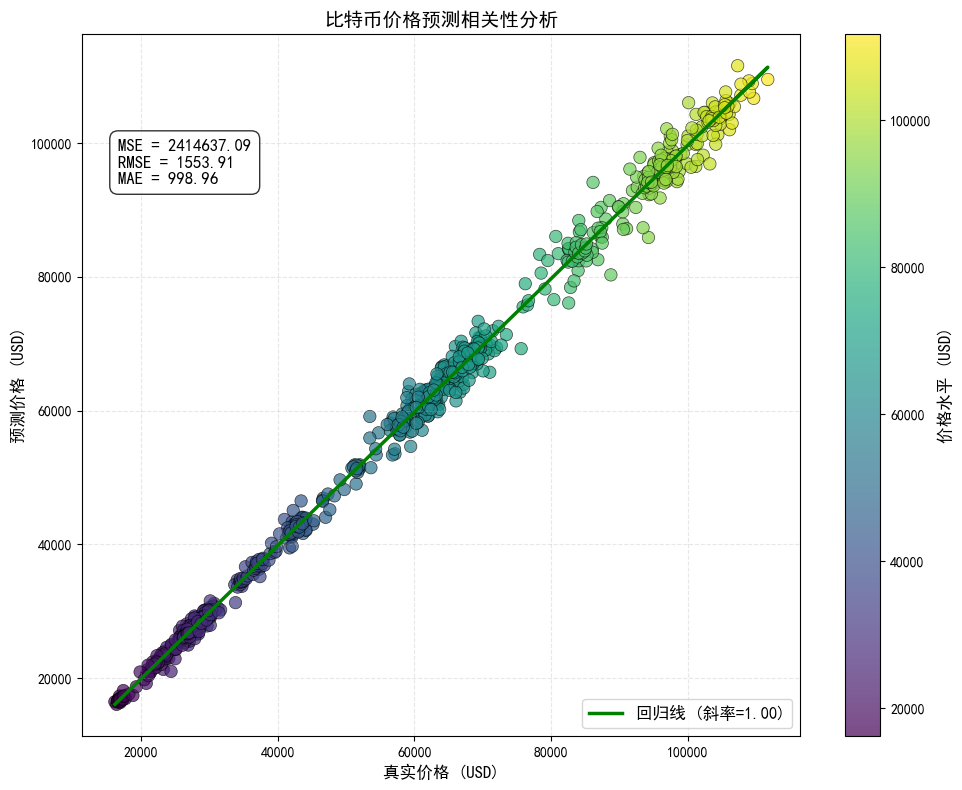

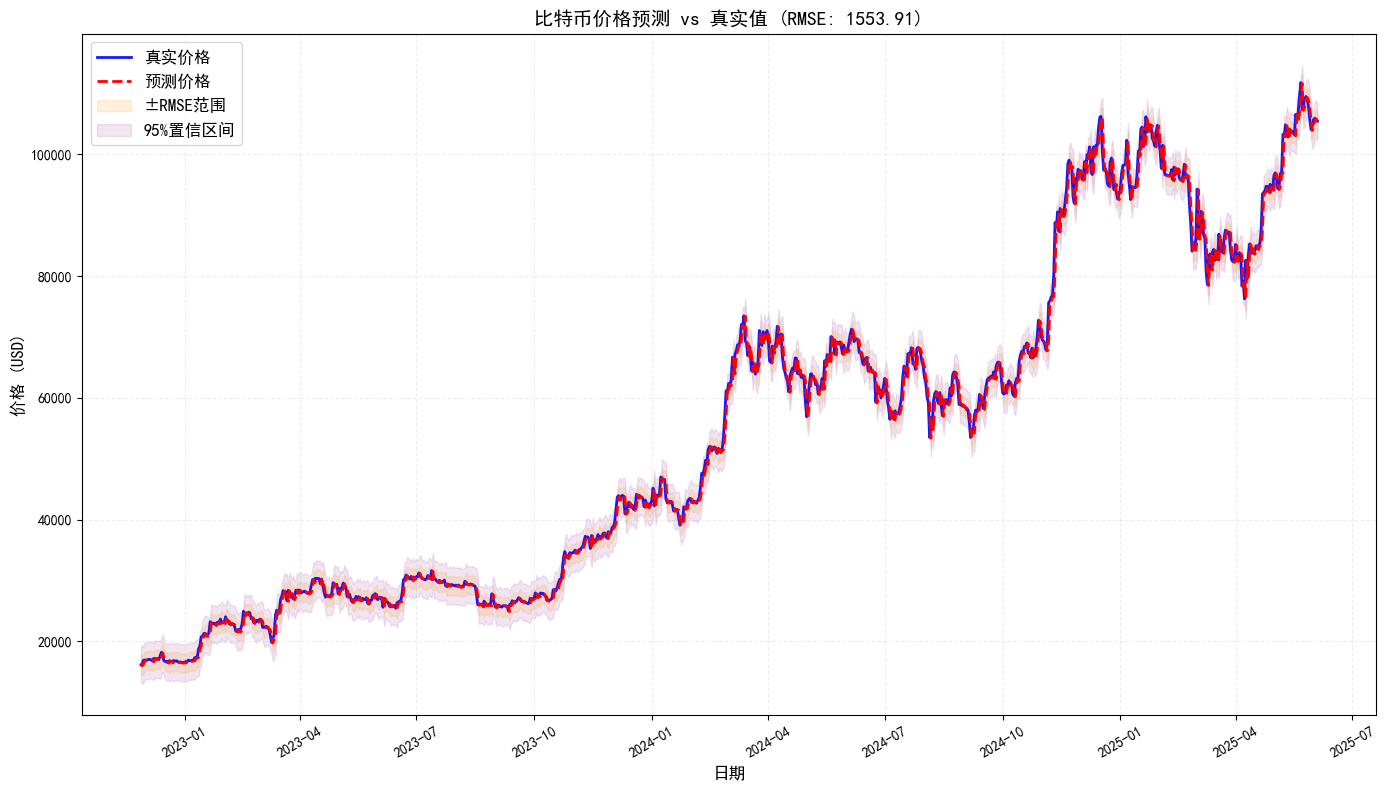

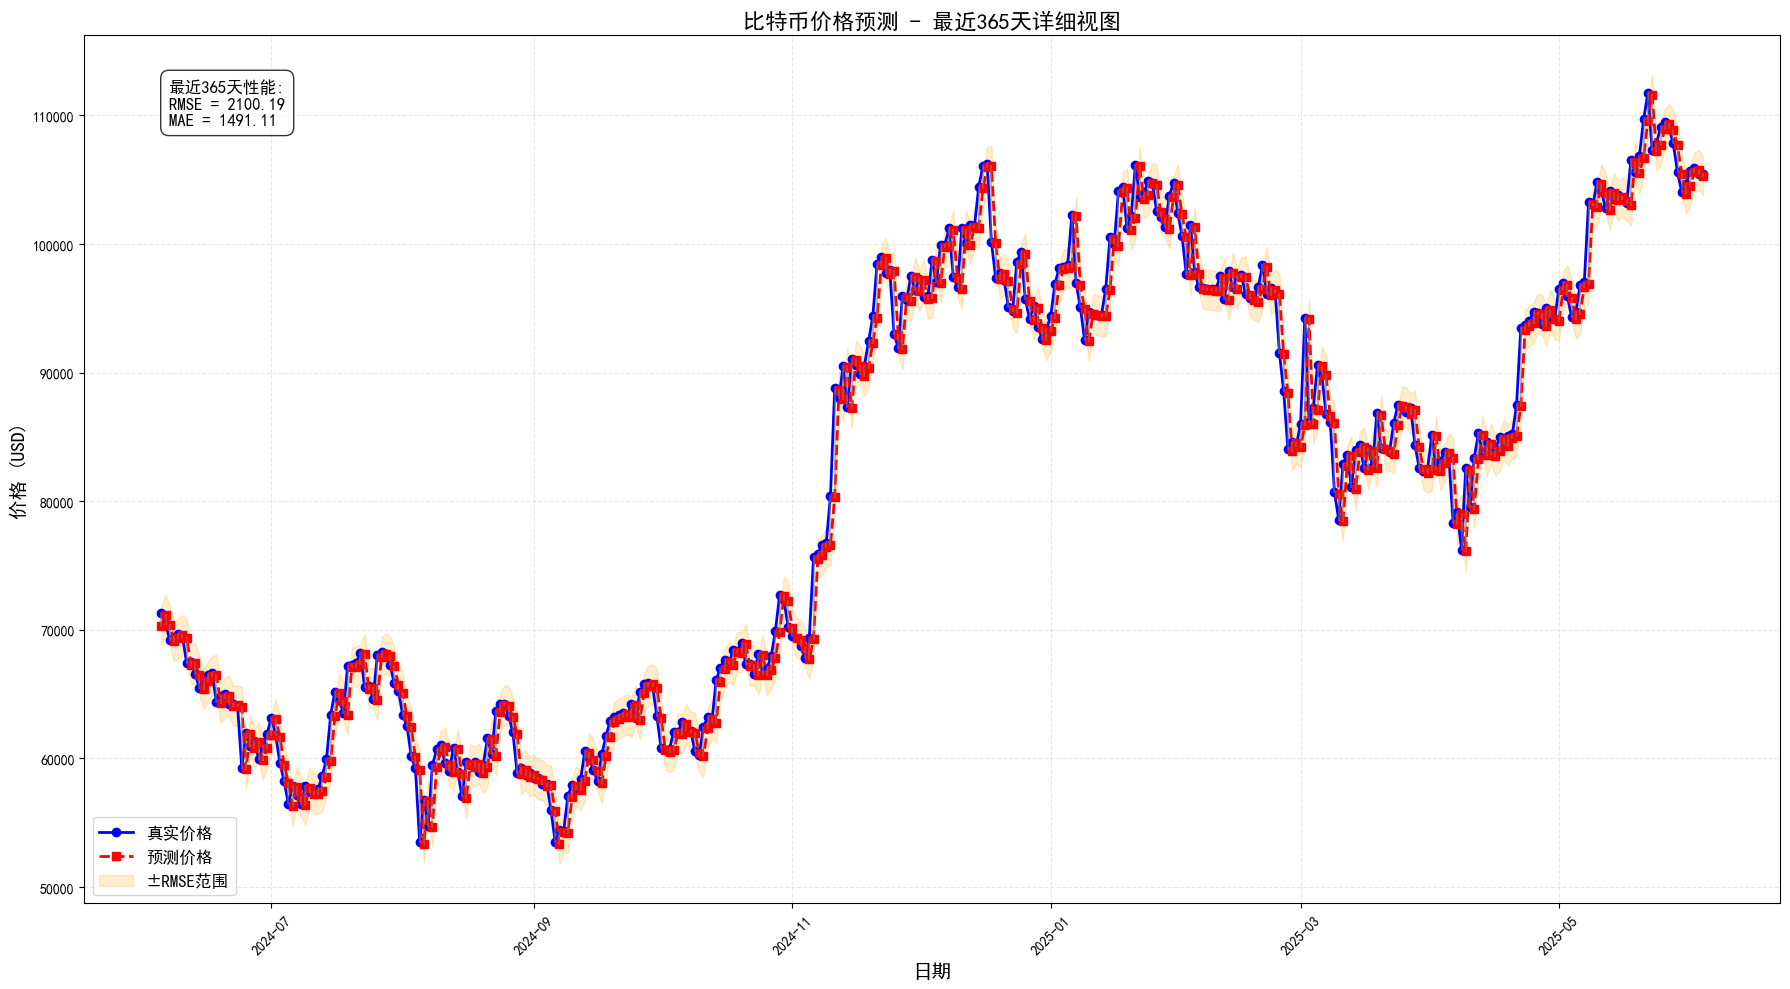

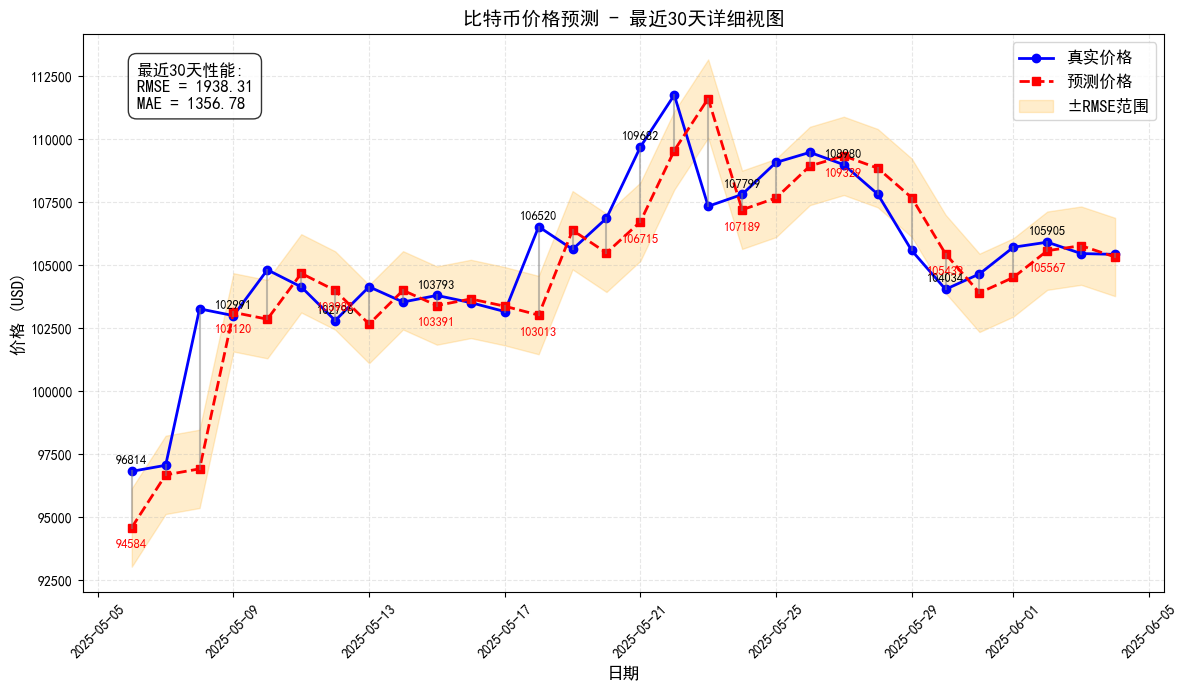

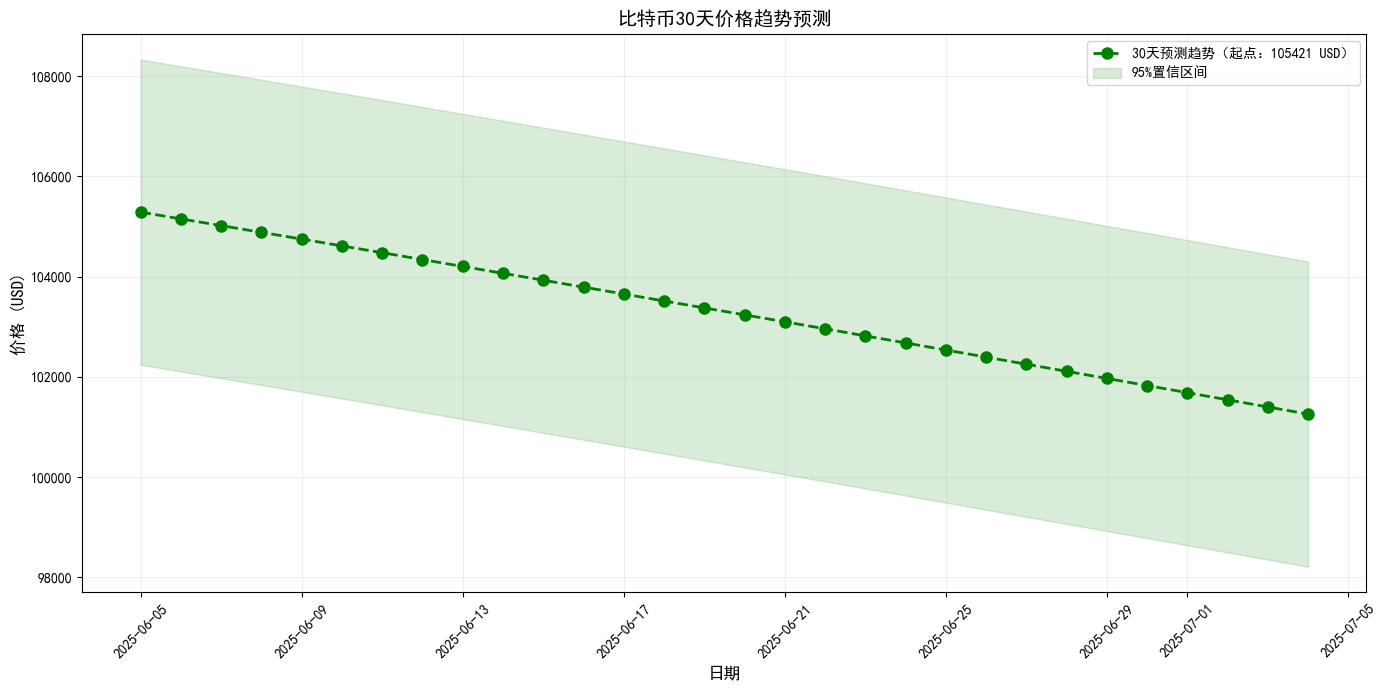

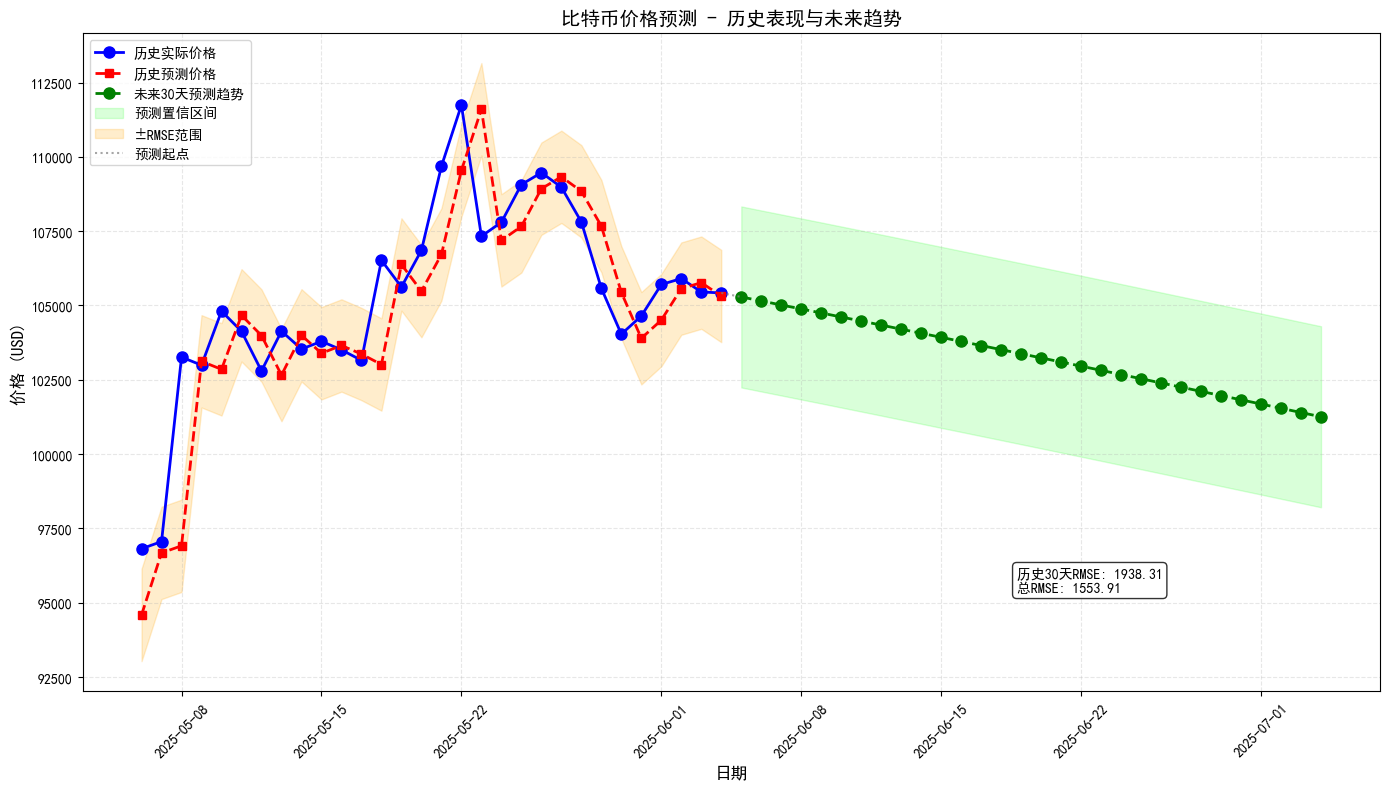

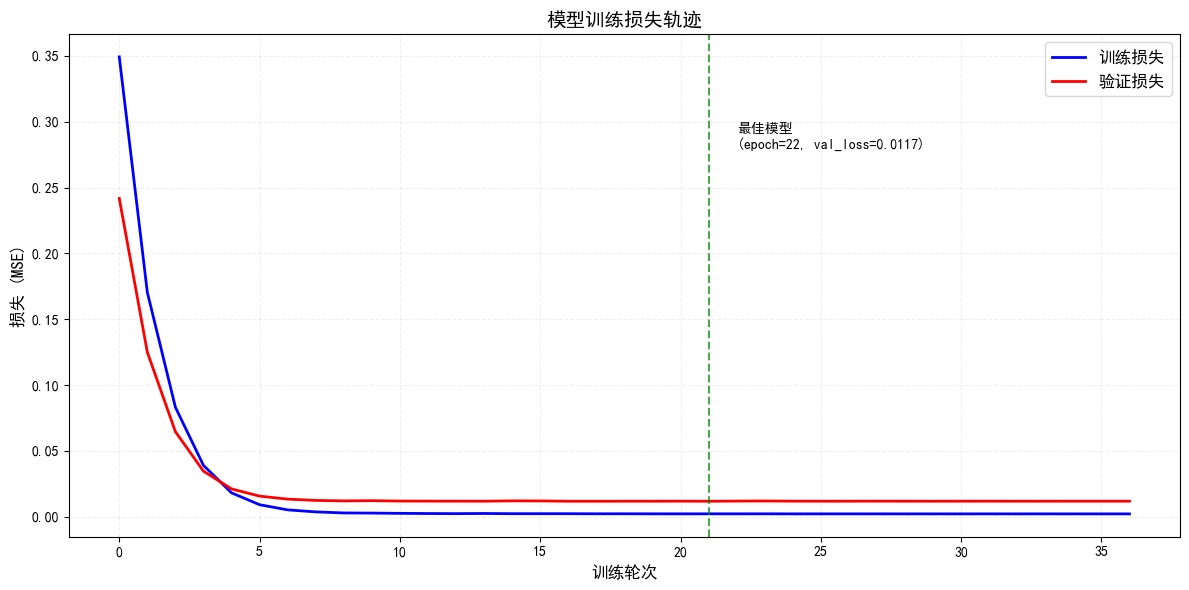

In [16]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Layer, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from scipy.stats import pearsonr
import re
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis
from statsmodels.tsa.seasonal import STL

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

# 自定义注意力层 
class TemporalAttention(Layer):
    def __init__(self, **kwargs):
        super(TemporalAttention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weights',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform')
        super(TemporalAttention, self).build(input_shape)
    
    def call(self, x):
        e = K.tanh(K.dot(x, self.W))  # 计算注意力能量
        a = K.softmax(e, axis=1)      # 生成注意力权重
        weighted_sum = K.sum(x * a, axis=1)  # 加权求和
        return K.expand_dims(weighted_sum, axis=1)  # 扩展为三维张量 (batch_size, 1, features)

# 数据预处理
def prepare_data(df, features, target_col='Close_diff', window_size=60, train_ratio=0.8):
    """多特征标准化和时间窗口生成"""
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # 划分数据集
    train_size = int(len(df) * train_ratio)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    
    # 多特征标准化
    scaled_train = scaler.fit_transform(train[features])
    scaled_test = scaler.transform(test[features])
    scaled_data = np.concatenate([scaled_train, scaled_test])
    
    # 创建时间窗口
    def create_dataset(data):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i+window_size, :])  # 多特征输入
            y.append(data[i+window_size, features.index(target_col)])  # 预测目标
        return np.array(X), np.array(y)
    
    return create_dataset(scaled_data), scaler, train_size

# 模型构建 
def build_enhanced_lstm(input_shape):
    """构建双向LSTM+Attention模型"""
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(TemporalAttention())
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# 新增多步预测函数
def recursive_forecast(model, initial_input, steps=30, feature_index=0):
    """
    递归预测未来多步价格
    :param initial_input: 初始输入数据 (shape: [1, window_size, features])
    :param steps: 预测步数
    :param feature_index: 目标特征在输入中的位置
    """
    predictions = []
    current_input = initial_input.copy()
    
    for _ in range(steps):
        # 预测下一步
        pred = model.predict(current_input, verbose=0)[0,0]
        predictions.append(pred)
        
        # 更新输入数据：移除最旧的时间步，添加新预测
        new_step = current_input[0, 1:, :]  # 保留中间时间步
        new_step = np.vstack([new_step, current_input[0, -1, :]])  # 复制最后一行
        new_step[-1, feature_index] = pred  # 更新目标特征
        
        current_input = np.expand_dims(new_step, axis=0)
    
    return np.array(predictions)

# 主程序 
if __name__ == "__main__":
    # 数据预处理
    # 加载数据
    df = pd.read_csv('btcusd_1-min_data.csv')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df.set_index('Timestamp', inplace=True)

    # 处理缺失值
    df.ffill(inplace=True)
    df.dropna(inplace=True)

    # 重采样为日级数据
    df_daily = df.resample('D').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    # 特征工程
    features = ['Close', 'Volume', 'High', 'Low', 'Open']  # 确保这些列在 df_daily 中存在
    target_col = 'Close_diff'  # 定义目标列名称

    # 添加目标列（价格差分）
    df_daily[target_col] = df_daily['Close'].diff().fillna(0)

    # 确保 target_col 在 features 列表中
    if target_col not in features:
        features.append(target_col)

    # 数据预处理
    window_size = 60
    (X, y), scaler, train_size = prepare_data(df_daily, features, target_col=target_col)
    X_train, X_test = X[:train_size - window_size], X[train_size - window_size:]
    y_train, y_test = y[:train_size - window_size], y[train_size - window_size:]

    # 构建和训练模型
    model = build_enhanced_lstm((window_size, len(features)))
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=64,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )

    # 预测与评估 
def inverse_transform(predictions, scaler, feature_idx=0):
    dummy = np.zeros((len(predictions), len(features)))
    dummy[:, feature_idx] = predictions.flatten()
    return scaler.inverse_transform(dummy)[:, feature_idx]

# 预测价格差分
pred_diff = model.predict(X_test)
pred_diff_orig = inverse_transform(pred_diff, scaler, features.index(target_col))

# 计算基础价格和真实价格
test_length = len(X_test)
start_index = train_size + window_size
end_index = start_index + test_length + 1

# 处理索引越界
if end_index > len(df_daily):
    end_index = len(df_daily)
    test_length = end_index - start_index - 1
    pred_diff_orig = pred_diff_orig[:test_length]  # 截断预测结果

base_prices = df_daily.iloc[start_index:end_index-1]['Close'].values
true_prices = df_daily.iloc[start_index+1:end_index]['Close'].values

    # 计算预测价格
pred_prices = base_prices + pred_diff_orig

mse = mean_squared_error(true_prices, pred_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_prices, pred_prices)
corr_coef, p_value = pearsonr(true_prices, pred_prices)

if p_value == 0:
    p_value = "< 5e-324"  # 处理浮点下溢（小于python所能显示的最小值）
else:
        # 动态计算需要的小数位数（确保显示非零值）
    precision = max(4, 4 - int(np.floor(np.log10(abs(p_value)))))
    p_value = f"{p_value:.{precision}e}"
    p_value = re.sub(r'0+e', 'e', p_value)

    # 可视化相关性
plt.figure(figsize=(10, 8))
plt.scatter(true_prices, pred_prices, alpha=0.7, s=80, c=true_prices, 
                cmap='viridis', edgecolor='k', linewidth=0.5)


    # 添加回归线
slope, intercept = np.polyfit(true_prices, pred_prices, 1)
regression_line = slope * np.array(true_prices) + intercept
plt.plot(true_prices, regression_line, 'g-', lw=2.5, label=f'回归线 (斜率={slope:.2f})')

# 添加统计信息文本框
stats_text = (f'MSE = {mse:.2f}\n'
                  f'RMSE = {rmse:.2f}\n'
                  f'MAE = {mae:.2f}')
plt.text(0.05, 0.85, stats_text, transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
             fontsize=12, verticalalignment='top')

# 添加颜色条
cbar = plt.colorbar()
cbar.set_label('价格水平 (USD)', fontsize=12)

plt.xlabel('真实价格 (USD)', fontsize=12, fontweight='bold')
plt.ylabel('预测价格 (USD)', fontsize=12, fontweight='bold')
plt.title('比特币价格预测相关性分析', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('price_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# 时间序列预测可视化
test_dates = df_daily.index[train_size + window_size + 1:train_size + window_size + 1 + len(true_prices)]

plt.figure(figsize=(14, 8))
plt.plot(test_dates, true_prices, 'b-', lw=2, label='真实价格', alpha=0.9)
plt.plot(test_dates, pred_prices, 'r--', lw=2, label='预测价格')
plt.fill_between(test_dates,
                     pred_prices - rmse,
                     pred_prices + rmse,
                     alpha=0.15, color='orange', label='±RMSE范围')

 # 添加预测区间
upper_bound = pred_prices + 1.96 * rmse
lower_bound = pred_prices - 1.96 * rmse
plt.fill_between(test_dates, lower_bound, upper_bound, 
                     alpha=0.1, color='purple', label='95%置信区间')

plt.title('比特币价格预测 vs 真实值 (RMSE: {:.2f})'.format(rmse), fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12, fontweight='bold')
plt.ylabel('价格 (USD)', fontsize=12, fontweight='bold')
plt.legend(fontsize=12, loc='upper left')
plt.grid(alpha=0.2, linestyle='--')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('price_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

# 最近365天详细视图（单独图表）
last_365_dates = test_dates[-365:]  # 获取最近365天的日期
last_365_true = true_prices[-365:]  # 获取最近365天的真实价格
last_365_pred = pred_prices[-365:]  # 获取最近365天的预测价格

plt.figure(figsize=(18, 10))
plt.plot(last_365_dates, last_365_true, 'b-o', lw=2, markersize=6, label='真实价格')
plt.plot(last_365_dates, last_365_pred, 'r--s', lw=2, markersize=6, label='预测价格')

# 添加预测区间
plt.fill_between(last_365_dates, 
                 last_365_pred - rmse, 
                 last_365_pred + rmse, 
                 alpha=0.2, color='orange', label='±RMSE范围')

# 添加误差线
for i, (true_val, pred_val) in enumerate(zip(last_365_true, last_365_pred)):
    plt.plot([last_365_dates[i], last_365_dates[i]], 
             [true_val, pred_val], 
             'gray', alpha=0.5, linestyle='-')
    

# 计算并显示最近365天的性能指标
last_365_mse = mean_squared_error(last_365_true, last_365_pred)
last_365_rmse = np.sqrt(last_365_mse)
last_365_mae = mean_absolute_error(last_365_true, last_365_pred)

# 添加性能指标框
stats_text = (f'最近365天性能:\n'
              f'RMSE = {last_365_rmse:.2f}\n'
              f'MAE = {last_365_mae:.2f}')
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
    fontsize=12, verticalalignment='top')

plt.title('比特币价格预测 - 最近365天详细视图', fontsize=16, fontweight='bold')
plt.xlabel('日期', fontsize=14, fontweight='bold')
plt.ylabel('价格 (USD)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('price_forecast_last365.png', dpi=300, bbox_inches='tight')
plt.show()

    # 最近30天详细视图（单独图表）
last_30_dates = test_dates[-30:]
last_30_true = true_prices[-30:]
last_30_pred = pred_prices[-30:]

plt.figure(figsize=(12, 7))
plt.plot(last_30_dates, last_30_true, 'b-o', lw=2, markersize=6, label='真实价格')
plt.plot(last_30_dates, last_30_pred, 'r--s', lw=2, markersize=6, label='预测价格')

    # 添加预测区间
plt.fill_between(last_30_dates, 
                     last_30_pred - rmse, 
                     last_30_pred + rmse, 
                     alpha=0.2, color='orange', label='±RMSE范围')

    # 添加误差线
for i, (true_val, pred_val) in enumerate(zip(last_30_true, last_30_pred)):
        plt.plot([last_30_dates[i], last_30_dates[i]], 
                 [true_val, pred_val], 
                 'gray', alpha=0.5, linestyle='-')
        
        if i % 3 == 0:  
            plt.annotate(f'{true_val:.0f}', 
                         (last_30_dates[i], true_val),
                         textcoords="offset points", 
                         xytext=(0,5), 
                         ha='center',
                         fontsize=9)
            plt.annotate(f'{pred_val:.0f}', 
                         (last_30_dates[i], pred_val),
                         textcoords="offset points", 
                         xytext=(0,-15), 
                         ha='center',
                         fontsize=9,
                         color='red')

    # 计算并显示最近30天的性能指标
last_30_mse = mean_squared_error(last_30_true, last_30_pred)
last_30_rmse = np.sqrt(last_30_mse)
last_30_mae = mean_absolute_error(last_30_true, last_30_pred)

    # 添加性能指标框
stats_text = (f'最近30天性能:\n'
                  f'RMSE = {last_30_rmse:.2f}\n'
                  f'MAE = {last_30_mae:.2f}')
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
             fontsize=12, verticalalignment='top')

plt.title('比特币价格预测 - 最近30天详细视图', fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12, fontweight='bold')
plt.ylabel('价格 (USD)', fontsize=12, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('price_forecast_last30.png', dpi=300, bbox_inches='tight')
plt.show()

last_window = X_test[-1:]  # 使用最后一个可用时间窗口
feature_idx = features.index(target_col)

# 执行递归预测
forecast_steps = 30
predicted_diffs = recursive_forecast(model, last_window, steps=forecast_steps, feature_index=feature_idx)

# 逆标准化预测结果
predicted_diffs_orig = inverse_transform(predicted_diffs.reshape(-1,1), scaler, feature_idx)

# 生成预测时间范围
last_date = df_daily.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)

# 计算绝对价格（基于最后一个已知价格）
last_price = df_daily['Close'].iloc[-1]
predicted_prices = last_price + np.cumsum(predicted_diffs_orig)

# 可视化趋势预测
plt.figure(figsize=(14, 7))
plt.plot(forecast_dates, predicted_prices, 'g--o', lw=2, markersize=8, 
        label=f'30天预测趋势（起点：{last_price:.0f} USD）')

# 添加置信区间（基于历史RMSE）
plt.fill_between(forecast_dates,
                predicted_prices - 1.96*rmse,
                predicted_prices + 1.96*rmse,
                alpha=0.15, color='green', label='95%置信区间')

plt.title('比特币30天价格趋势预测', fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('价格 (USD)', fontsize=12)
plt.grid(alpha=0.2)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('30_days_forecast.png', dpi=300)
plt.show()
plt.figure(figsize=(14, 8))
    
    # 绘制历史实际价格
plt.plot(last_30_dates, last_30_true, 'b-o', lw=2, markersize=8, label='历史实际价格')
    
    # 绘制历史预测价格
plt.plot(last_30_dates, last_30_pred, 'r--s', lw=2, markersize=6, label='历史预测价格')
    
    # 绘制未来预测价格（连接最后一个历史日期）
plt.plot(forecast_dates, predicted_prices, 'g--o', lw=2, markersize=8, 
            label=f'未来30天预测趋势')

    # 添加预测区间
plt.fill_between(forecast_dates,
                    predicted_prices - 1.96*rmse,
                    predicted_prices + 1.96*rmse,
                    alpha=0.15, color='lime', label='预测置信区间')
    # 添加历史误差范围指示器
plt.annotate(f'历史30天RMSE: {last_30_rmse:.2f}\n总RMSE: {rmse:.2f}',
                xy=(0.72, 0.15), xycoords='axes fraction',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=10)
   # 添加预测区间
plt.fill_between(last_30_dates, 
                     last_30_pred - rmse, 
                     last_30_pred + rmse, 
                     alpha=0.2, color='orange', label='±RMSE范围')

    # 连接最后一个历史点和第一个预测点
connection_date = [last_30_dates[-1], forecast_dates[0]]
connection_price = [last_30_true[-1], predicted_prices[0]]
plt.plot(connection_date, connection_price, 'gray', linestyle=':', 
        alpha=0.7, label='预测起点')

plt.title('比特币价格预测 - 历史表现与未来趋势', fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12, fontweight='bold')
plt.ylabel('价格 (USD)', fontsize=12, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('price_forecast_with_future.png', dpi=300, bbox_inches='tight')
plt.show()
    

# 训练过程可视化
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], 'b-', lw=2, label='训练损失')
plt.plot(history.history['val_loss'], 'r-', lw=2, label='验证损失')
plt.title('模型训练损失轨迹', fontsize=14, fontweight='bold')
plt.ylabel('损失 (MSE)', fontsize=12)
plt.xlabel('训练轮次', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.2, linestyle='--')

# 标记最佳模型位置
best_epoch = np.argmin(history.history['val_loss'])
best_val_loss = np.min(history.history['val_loss'])
plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7)
plt.text(best_epoch+1, max(history.history['loss'])*0.8, 
            f'最佳模型\n(epoch={best_epoch+1}, val_loss={best_val_loss:.4f})',
            fontsize=10)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()


